In [1]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model, fit_report
from lmfit.models import LinearModel
from pandas import read_csv

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath('./../plots/temp')+'/'

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)

from pyresample.geometry import SwathDefinition
from pyresample import kd_tree, image
import cartopy.crs as ccrs
import matplotlib.path as mpath

##################

h3p_density = fits.open('h3p_dens_v2.fits', ignore_missing_end=True)[0].data
h3p_temperature = fits.open('h3p_temp_v2.fits', ignore_missing_end=True)[0].data
h3p_density_errs = fits.open('h3p_dens_errs_v2.fits', ignore_missing_end=True)[0].data
h3p_temperature_errs = fits.open('h3p_temp_errs_v2.fits', ignore_missing_end=True)[0].data
h3p_radiance = fits.open('h3p_radiance_v2.fits', ignore_missing_end=True)[0].data
h3p_radiance_errs = fits.open('h3p_radiance_errs_v2.fits', ignore_missing_end=True)[0].data

eff_ion_drift = fits.open('eff_ion_drift.fits', ignore_missing_end=True)[0].data
eff_ion_drift_errs = fits.open('eff_ion_drift_errs.fits', ignore_missing_end=True)[0].data
eff_ion_drift_ss = fits.open('eff_ion_drift_ss.fits', ignore_missing_end=True)[0].data

ion_drift = fits.open('ion_drift_prf.fits', ignore_missing_end=True)[0].data
ion_drift_errs = fits.open('ion_drift_errs.fits', ignore_missing_end=True)[0].data
neutral_drift = fits.open('neutral_drift_prf.fits', ignore_missing_end=True)[0].data
neutral_drift_errs = fits.open('neutral_drift_errs.fits', ignore_missing_end=True)[0].data

h2_density = fits.open('h2_dens.fits', ignore_missing_end=True)[0].data
h2_temperature = fits.open('h2_temp.fits', ignore_missing_end=True)[0].data
h2_density_errs = fits.open('h2_dens_errs.fits', ignore_missing_end=True)[0].data
h2_temperature_errs = fits.open('h2_temp_errs.fits', ignore_missing_end=True)[0].data
h2_radiance = fits.open('h2_radiance.fits', ignore_missing_end=True)[0].data
h2_radiance_errs = fits.open('h2_radiance_errs.fits', ignore_missing_end=True)[0].data

h2_density_v2 = fits.open('h2_dens_v2.fits', ignore_missing_end=True)[0].data
h2_temperature_v2 = fits.open('h2_temp_v2.fits', ignore_missing_end=True)[0].data
h2_density_errs_v2 = fits.open('h2_dens_errs_v2.fits', ignore_missing_end=True)[0].data
h2_temperature_errs_v2 = fits.open('h2_temp_errs_v2.fits', ignore_missing_end=True)[0].data
h2_radiance_v2 = fits.open('h2_radiance_v2.fits', ignore_missing_end=True)[0].data
h2_radiance_errs_v2 = fits.open('h2_radiance_errs_v2.fits', ignore_missing_end=True)[0].data

ref_sun = fits.open('ref_sun.fits', ignore_missing_end=True)[0].data

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

h2_int = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data * (waverange36[71:121][1] - waverange36[71:121][0])
h2_int_errs = fits.open('h2_int_shifted_error.fits', ignore_missing_end=True)[0].data * (waverange36[71:121][1] - waverange36[71:121][0])


##################

cmlsel = read_csv("cml-sel.txt", sep="\s+", header=None)
cml = cmlsel[3].to_numpy()

sub_earth_lat = -3.098

ang_diam_first_scan = 40.59098 * (((71492 + 800) / 71492 - 1)*2 + 1)
r_first_scan = ang_diam_first_scan / (0.1) / 2

ang_diam_second_scan = 40.58867 * (((71492 + 800) / 71492 - 1)*2 + 1)
r_second_scan = ang_diam_second_scan / (0.1) / 2

north_pole_posangle = 0

init_x = 150  
init_y = 182  # (99.5 * 0.183) / 0.1 

dat_first_scan = h3p_temperature[:16]
dat_second_scan = h3p_temperature[16:]

lat_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])
lon_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])

lat_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])
lon_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])

los_corr_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])
los_corr_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])

for j in range(dat_first_scan.shape[0]):
    for i in range(dat_first_scan.shape[1]):
        x = i - init_x
        y_first_scan = init_y - (0.1716 / 0.1 * j)  # * (0.288 / 0.2) # 15 * 0.183 / 16

        lat_first_scan, lon_first_scan, los_corr_first_scan = rhp.slit_to_lat_long(x, 
                                                              y_first_scan, 
                                                              r_first_scan, 
                                                              sub_earth_lat, 
                                                              north_pole_posangle, 
                                                              cml[j],
                                                             )

        lat_array_first_scan[j][i] = lat_first_scan[4]
        lon_array_first_scan[j][i] = lon_first_scan[4]
        los_corr_array_first_scan[j][i] = los_corr_first_scan[4]

for j in range(dat_second_scan.shape[0]):
    for i in range(dat_second_scan.shape[1]):
        x = i - init_x
        y_second_scan = init_y - (0.1747 / 0.1 * j)  # * (0.288 / 0.2) # 21 * 0.183 / 22

        lat_second_scan, lon_second_scan, los_corr_second_scan = rhp.slit_to_lat_long(x, 
                                                                y_second_scan, 
                                                                r_second_scan, 
                                                                sub_earth_lat, 
                                                                north_pole_posangle, 
                                                                cml[j + 16],
                                                               )

        lat_array_second_scan[j][i] = lat_second_scan[4]
        lon_array_second_scan[j][i] = lon_second_scan[4]
        los_corr_array_second_scan[j][i] = los_corr_second_scan[4]

los_corr_array = np.vstack([los_corr_array_first_scan, los_corr_array_second_scan])

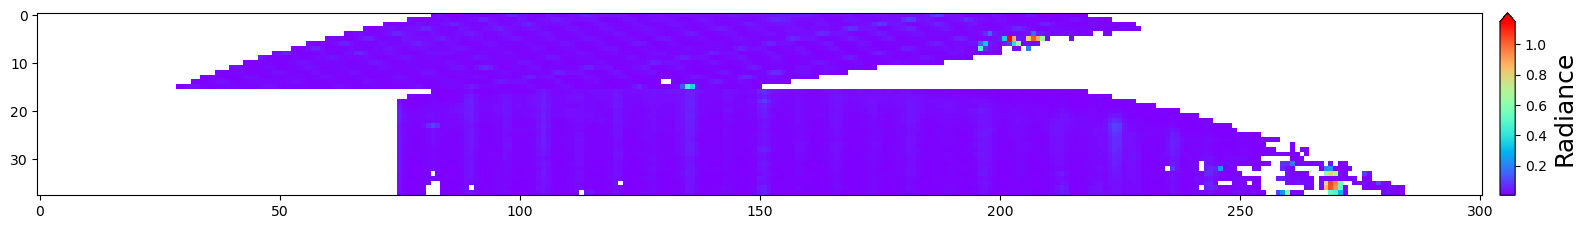

In [4]:
h2_int_los_corr = h2_int * los_corr_array
h2_int_los_corr[h2_int_los_corr < 1e-9] = np.nan
h2_int_errs[np.isnan(h2_int_los_corr)] = np.nan

fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(511)
plt.imshow(h2_int_errs*1e6, cmap='rainbow',)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Radiance',size=18)

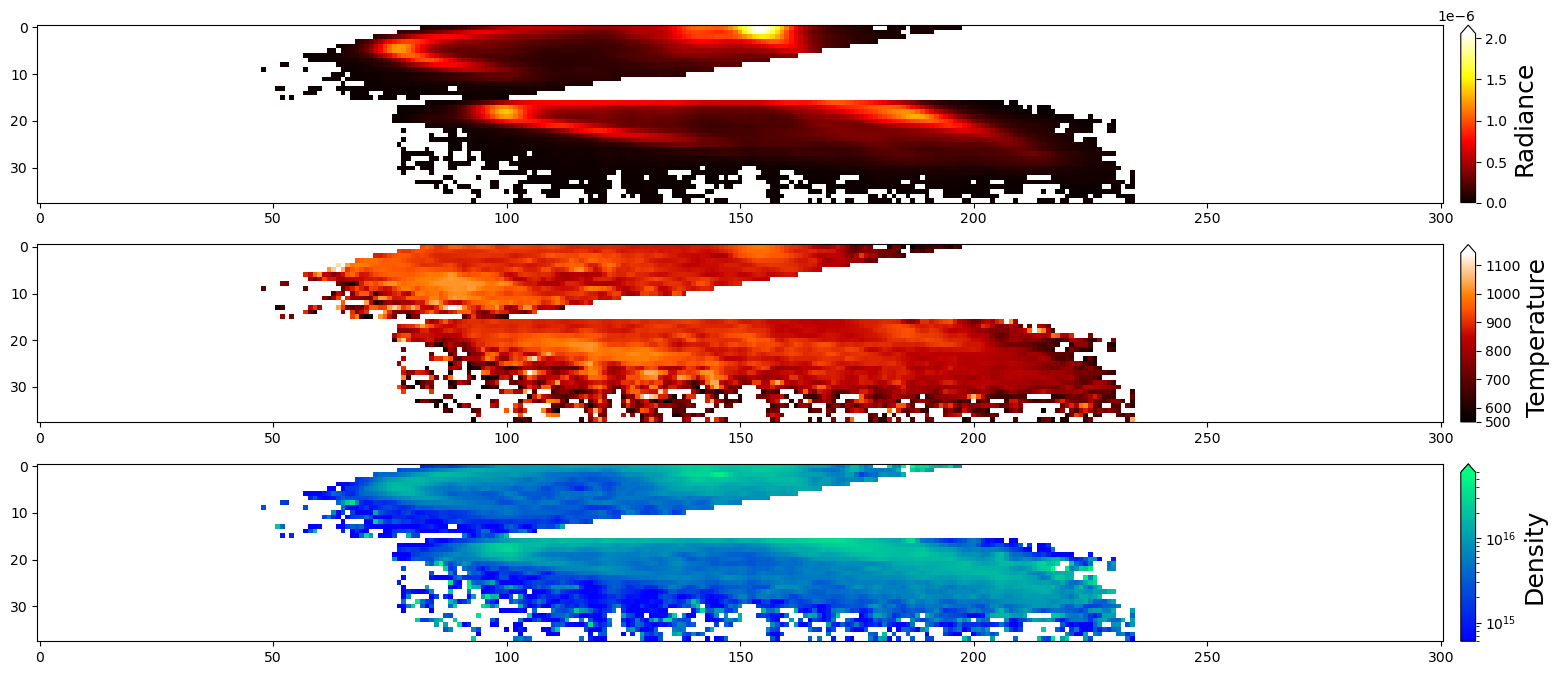

In [3]:
h3p_rad_los_corr = h3p_radiance*los_corr_array
h3p_dens_los_corr = h3p_density*los_corr_array
h3p_temp = h3p_temperature.copy() 

h3p_temp_errs = h3p_temperature_errs.copy()
h3p_dens_errs = h3p_density_errs.copy()
h3p_rad_errs = h3p_radiance_errs.copy()

h3p_rad_los_corr[h3p_rad_los_corr < 1e-8] = np.nan
h3p_temp[h3p_temp > 1200] = np.nan
h3p_temp[h3p_temp < 550] = np.nan

h3p_temp[np.isnan(h3p_rad_los_corr)] = np.nan
h3p_rad_los_corr[np.isnan(h3p_temp)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_rad_los_corr)] = np.nan

h3p_temp_errs[np.isnan(h3p_rad_los_corr)] = np.nan
h3p_dens_errs[np.isnan(h3p_rad_los_corr)] = np.nan
h3p_rad_errs[np.isnan(h3p_rad_los_corr)] = np.nan

a = 0
b = 40

fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(511)
plt.imshow(h3p_rad_los_corr[a:b], cmap='hot', norm=colors.PowerNorm(gamma=1,))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Radiance',size=18)

fig.add_subplot(512)
plt.imshow(h3p_temp[a:b], cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature',size=18)

fig.add_subplot(513)
plt.imshow(h3p_dens_los_corr[a:b], cmap='winter', norm=colors.LogNorm(vmin=6e14, vmax=6e16))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density',size=18)

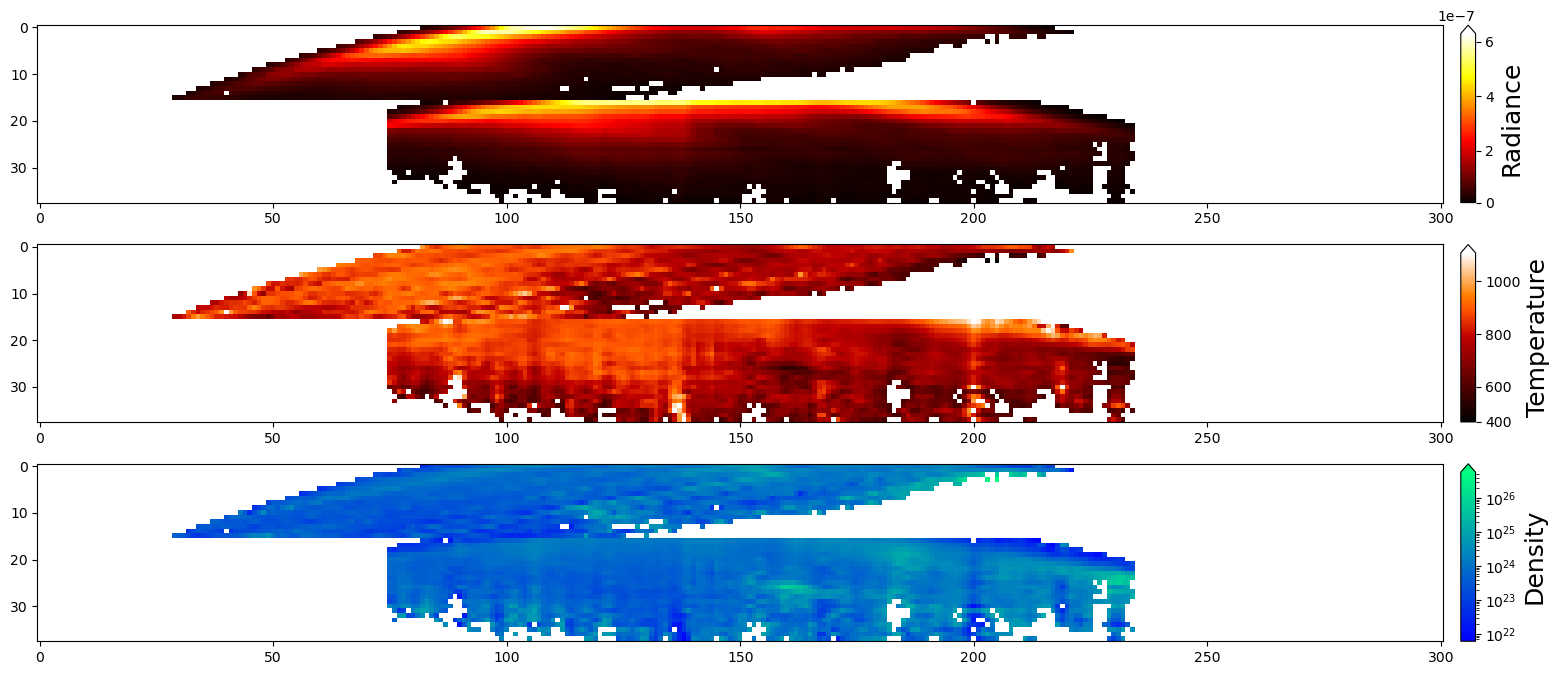

In [4]:
h2_rad_los_corr = h2_radiance*los_corr_array
h2_dens_los_corr = h2_density*los_corr_array
h2_temp = h2_temperature.copy()

h2_temp_errs = h2_temperature_errs.copy()
h2_dens_errs = h2_density_errs.copy()
h2_rad_errs = h2_radiance_errs.copy()

h2_rad_los_corr[h2_rad_los_corr < 1e-8] = np.nan

h2_temp[np.isnan(h2_rad_los_corr)] = np.nan
h2_rad_los_corr[np.isnan(h2_temp)] = np.nan
h2_dens_los_corr[np.isnan(h2_rad_los_corr)] = np.nan

h2_temp_errs[np.isnan(h2_rad_los_corr)] = np.nan
h2_dens_errs[np.isnan(h2_rad_los_corr)] = np.nan
h2_rad_errs[np.isnan(h2_rad_los_corr)] = np.nan

a = 0
b = 40

fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(511)
plt.imshow(h2_rad_los_corr[a:b], cmap='hot', norm=colors.PowerNorm(gamma=1,))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Radiance',size=18)

fig.add_subplot(512)
plt.imshow(h2_temp[a:b], cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature',size=18)

fig.add_subplot(513)
plt.imshow(h2_dens_los_corr[a:b], cmap='winter', norm=colors.LogNorm())
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density',size=18)

In [69]:
a = 0
b = 8

print(np.nanmean(h2_temp[a:b])) 
print('{:.3e}'.format(np.nanmean(h2_dens_los_corr[a:b])))
print(np.nanmean(h3p_temp[a:b]))
print('{:.3e}'.format(np.nanmean(h3p_dens_los_corr[a:b])))

print(np.nanmean(h2_temp_errs[a:b])) 
print('{:.3e}'.format(np.nanmean(h2_dens_errs[a:b])))
print(np.nanmean(h3p_temp_errs[a:b]))
print('{:.3e}'.format(np.nanmean(h3p_dens_errs[a:b])))

a = 16
b = 24

print(np.nanmean(h2_temp[a:b])) 
print('{:.3e}'.format(np.nanmean(h2_dens_los_corr[a:b])))
print(np.nanmean(h3p_temp[a:b]))
print('{:.3e}'.format(np.nanmean(h3p_dens_los_corr[a:b])))

print(np.nanmean(h2_temp_errs[a:b])) 
print('{:.3e}'.format(np.nanmean(h2_dens_errs[a:b])))
print(np.nanmean(h3p_temp_errs[a:b]))
print('{:.3e}'.format(np.nanmean(h3p_dens_errs[a:b])))

807.2052017691851
2.923e+24
889.4552585280135
9.588e+15
38.79337903297626
4.459e+24
35.970171720420275
5.715e+15
838.9870359383441
1.415e+24
876.3883618213471
9.444e+15
23.033548619880897
7.322e+23
44.88282251660986
6.099e+15


In [5]:
iospot = read_csv("grodent_iospot.dat", sep="\s+", header=None)
main_oval = read_csv("grodent_main_ovals.dat", sep="\s+", header=None)

main_oval_lat = main_oval[1].to_numpy()
main_oval_long = main_oval[0].to_numpy()

io_lat = iospot[1].to_numpy()
io_long = iospot[0].to_numpy()

grid_lat, grid_long = np.mgrid[-90:90:181j, -180:180:361j]


#### first scan

map_lat_first_scan = np.array(lat_array_first_scan)
map_long_first_scan = np.array(lon_array_first_scan)

map_long_first_scan[map_long_first_scan > 180] -= 360

source_def_first_scan = SwathDefinition(lons=map_long_first_scan, lats=map_lat_first_scan)
target_def_first_scan = SwathDefinition(lons=grid_long, lats=grid_lat)


# h3p temp
im = h3p_temp[:16]
errs = h3p_temp_errs[:16]

mapped_temp_h3p_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                       im, 
                                                       target_def_first_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_temp_h3p_first_scan = np.roll(mapped_temp_h3p_first_scan, 180, axis=1)
rolled_temp_h3p_first_scan[rolled_temp_h3p_first_scan == 0] = np.nan

mapped_temp_h3p_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                       errs, 
                                                       target_def_first_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_temp_h3p_first_scan_errs = np.roll(mapped_temp_h3p_first_scan_errs, 180, axis=1)
rolled_temp_h3p_first_scan_errs[np.isnan(rolled_temp_h3p_first_scan)] = np.nan


# h3p dens
im = h3p_dens_los_corr[:16]
errs = h3p_dens_errs[:16]

mapped_dens_h3p_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                       im, 
                                                       target_def_first_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_dens_h3p_first_scan = np.roll(mapped_dens_h3p_first_scan, 180, axis=1)
rolled_dens_h3p_first_scan[rolled_dens_h3p_first_scan == 0] = np.nan

mapped_dens_h3p_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                       errs, 
                                                       target_def_first_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_dens_h3p_first_scan_errs = np.roll(mapped_dens_h3p_first_scan_errs, 180, axis=1)
rolled_dens_h3p_first_scan_errs[np.isnan(rolled_dens_h3p_first_scan)] = np.nan


# h3p radiance
im = h3p_rad_los_corr[:16]
errs = h3p_rad_errs[:16]

mapped_radiance_h3p_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                      im, 
                                                      target_def_first_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_radiance_h3p_first_scan = np.roll(mapped_radiance_h3p_first_scan, 180, axis=1)
rolled_radiance_h3p_first_scan[rolled_radiance_h3p_first_scan == 0] = np.nan

mapped_radiance_h3p_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                      errs, 
                                                      target_def_first_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_radiance_h3p_first_scan_errs = np.roll(mapped_radiance_h3p_first_scan_errs, 180, axis=1)
rolled_radiance_h3p_first_scan_errs[np.isnan(rolled_radiance_h3p_first_scan)] = np.nan


# h2 temp
im = h2_temp[:16]
errs = h2_temp_errs[:16]

mapped_temp_h2_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                     im, 
                                                     target_def_first_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_temp_h2_first_scan = np.roll(mapped_temp_h2_first_scan, 180, axis=1)
rolled_temp_h2_first_scan[rolled_temp_h2_first_scan == 0] = np.nan

mapped_temp_h2_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                     errs, 
                                                     target_def_first_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_temp_h2_first_scan_errs = np.roll(mapped_temp_h2_first_scan_errs, 180, axis=1)
rolled_temp_h2_first_scan_errs[np.isnan(rolled_temp_h2_first_scan)] = np.nan


# h2 dens
im = h2_dens_los_corr[:16]
errs = h2_dens_errs[:16]

mapped_dens_h2_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                     im, 
                                                     target_def_first_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_dens_h2_first_scan = np.roll(mapped_dens_h2_first_scan, 180, axis=1)
rolled_dens_h2_first_scan[rolled_dens_h2_first_scan == 0] = np.nan

mapped_dens_h2_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                     errs, 
                                                     target_def_first_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_dens_h2_first_scan_errs = np.roll(mapped_dens_h2_first_scan_errs, 180, axis=1)
rolled_dens_h2_first_scan_errs[np.isnan(rolled_dens_h2_first_scan)] = np.nan


# h2 radiance
im = h2_rad_los_corr[:16]
errs = h2_rad_errs[:16]

mapped_radiance_h2_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                    im, 
                                                    target_def_first_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_radiance_h2_first_scan = np.roll(mapped_radiance_h2_first_scan, 180, axis=1)
rolled_radiance_h2_first_scan[rolled_radiance_h2_first_scan == 0] = np.nan

mapped_radiance_h2_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                    errs, 
                                                    target_def_first_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_radiance_h2_first_scan_errs = np.roll(mapped_radiance_h2_first_scan_errs, 180, axis=1)
rolled_radiance_h2_first_scan_errs[np.isnan(rolled_radiance_h2_first_scan)] = np.nan


# ref sun
im = ref_sun[:16]

mapped_ref_sun_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                     im, 
                                                     target_def_first_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_ref_sun_first_scan = np.roll(mapped_ref_sun_first_scan, 180, axis=1)
rolled_ref_sun_first_scan[rolled_ref_sun_first_scan == 0] = np.nan


# h2 int
im = h2_int_los_corr[:16]
errs = h2_int_errs[:16]

mapped_int_h2_first_scan = kd_tree.resample_nearest(source_def_first_scan, 
                                                    im, 
                                                    target_def_first_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_int_h2_first_scan = np.roll(mapped_int_h2_first_scan, 180, axis=1)
rolled_int_h2_first_scan[rolled_int_h2_first_scan == 0] = np.nan

mapped_int_h2_first_scan_errs = kd_tree.resample_nearest(source_def_first_scan, 
                                                    errs, 
                                                    target_def_first_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_int_h2_first_scan_errs = np.roll(mapped_int_h2_first_scan_errs, 180, axis=1)
rolled_int_h2_first_scan_errs[np.isnan(rolled_int_h2_first_scan)] = np.nan


#### second scan

map_lat_second_scan = np.array(lat_array_second_scan)
map_long_second_scan = np.array(lon_array_second_scan)

map_long_second_scan[map_long_second_scan > 180] -= 360

source_def_second_scan = SwathDefinition(lons=map_long_second_scan, lats=map_lat_second_scan)
target_def_second_scan = SwathDefinition(lons=grid_long, lats=grid_lat)


# h3p temp
im = h3p_temp[16:]
errs = h3p_temp_errs[16:]

mapped_temp_h3p_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                       im, 
                                                       target_def_second_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_temp_h3p_second_scan = np.roll(mapped_temp_h3p_second_scan, 180, axis=1)
rolled_temp_h3p_second_scan[rolled_temp_h3p_second_scan == 0] = np.nan

mapped_temp_h3p_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                       errs, 
                                                       target_def_second_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_temp_h3p_second_scan_errs = np.roll(mapped_temp_h3p_second_scan_errs, 180, axis=1)
rolled_temp_h3p_second_scan_errs[np.isnan(rolled_temp_h3p_second_scan)] = np.nan

# h3p dens
im = h3p_dens_los_corr[16:]
errs = h3p_dens_errs[16:]

mapped_dens_h3p_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                       im, 
                                                       target_def_second_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_dens_h3p_second_scan = np.roll(mapped_dens_h3p_second_scan, 180, axis=1)
rolled_dens_h3p_second_scan[rolled_dens_h3p_second_scan == 0] = np.nan

mapped_dens_h3p_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                       errs, 
                                                       target_def_second_scan, 
                                                       radius_of_influence=2e5, 
                                                       epsilon=0.5, 
                                                      )

rolled_dens_h3p_second_scan_errs = np.roll(mapped_dens_h3p_second_scan_errs, 180, axis=1)
rolled_dens_h3p_second_scan_errs[np.isnan(rolled_dens_h3p_second_scan)] = np.nan

# h3p radiance
im = h3p_rad_los_corr[16:]
errs = h3p_rad_errs[16:]

mapped_radiance_h3p_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                      im, 
                                                      target_def_second_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_radiance_h3p_second_scan = np.roll(mapped_radiance_h3p_second_scan, 180, axis=1)
rolled_radiance_h3p_second_scan[rolled_radiance_h3p_second_scan == 0] = np.nan

mapped_radiance_h3p_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                      errs, 
                                                      target_def_second_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_radiance_h3p_second_scan_errs = np.roll(mapped_radiance_h3p_second_scan_errs, 180, axis=1)
rolled_radiance_h3p_second_scan_errs[np.isnan(rolled_radiance_h3p_second_scan)] = np.nan


# h2 temp
im = h2_temp[16:]
errs = h2_temp_errs[16:]

mapped_temp_h2_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                      im, 
                                                      target_def_second_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_temp_h2_second_scan = np.roll(mapped_temp_h2_second_scan, 180, axis=1)
rolled_temp_h2_second_scan[rolled_temp_h2_second_scan == 0] = np.nan

mapped_temp_h2_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                     errs, 
                                                     target_def_second_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_temp_h2_second_scan_errs = np.roll(mapped_temp_h2_second_scan_errs, 180, axis=1)
rolled_temp_h2_second_scan_errs[np.isnan(rolled_temp_h2_second_scan)] = np.nan


# h2 dens
im = h2_dens_los_corr[16:]
errs = h2_dens_errs[16:]

mapped_dens_h2_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                      im, 
                                                      target_def_second_scan, 
                                                      radius_of_influence=2e5, 
                                                      epsilon=0.5, 
                                                     )

rolled_dens_h2_second_scan = np.roll(mapped_dens_h2_second_scan, 180, axis=1)
rolled_dens_h2_second_scan[rolled_dens_h2_second_scan == 0] = np.nan

mapped_dens_h2_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                     errs, 
                                                     target_def_second_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_dens_h2_second_scan_errs = np.roll(mapped_dens_h2_second_scan_errs, 180, axis=1)
rolled_dens_h2_second_scan_errs[np.isnan(rolled_dens_h2_second_scan)] = np.nan

# h2 radiance
im = h2_rad_los_corr[16:]
errs = h2_rad_errs[16:]

mapped_radiance_h2_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                     im, 
                                                     target_def_second_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_radiance_h2_second_scan = np.roll(mapped_radiance_h2_second_scan, 180, axis=1)
rolled_radiance_h2_second_scan[rolled_radiance_h2_second_scan == 0] = np.nan

mapped_radiance_h2_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                    errs, 
                                                    target_def_second_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_radiance_h2_second_scan_errs = np.roll(mapped_radiance_h2_second_scan_errs, 180, axis=1)
rolled_radiance_h2_second_scan_errs[np.isnan(rolled_radiance_h2_second_scan)] = np.nan

# ref sun
im = ref_sun[16:]

mapped_ref_sun_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                     im, 
                                                     target_def_second_scan, 
                                                     radius_of_influence=2e5, 
                                                     epsilon=0.5, 
                                                    )

rolled_ref_sun_second_scan = np.roll(mapped_ref_sun_second_scan, 180, axis=1)
rolled_ref_sun_second_scan[rolled_ref_sun_second_scan == 0] = np.nan

# h2 int
im = h2_int_los_corr[16:]
errs = h2_int_errs[16:]

mapped_int_h2_second_scan = kd_tree.resample_nearest(source_def_second_scan, 
                                                    im, 
                                                    target_def_second_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_int_h2_second_scan = np.roll(mapped_int_h2_second_scan, 180, axis=1)
rolled_int_h2_second_scan[rolled_int_h2_second_scan == 0] = np.nan

mapped_int_h2_second_scan_errs = kd_tree.resample_nearest(source_def_second_scan, 
                                                    errs, 
                                                    target_def_second_scan, 
                                                    radius_of_influence=2e5, 
                                                    epsilon=0.5, 
                                                   )

rolled_int_h2_second_scan_errs = np.roll(mapped_int_h2_second_scan_errs, 180, axis=1)
rolled_int_h2_second_scan_errs[np.isnan(rolled_int_h2_second_scan)] = np.nan


# projection config
data_crs = ccrs.PlateCarree()

lon = np.linspace(0, 360, 361)
lat = np.linspace(-90, 90, 181)

theta = np.linspace(-0.5*np.pi, -1.5*np.pi, 200)
# theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.505, 0.5], 0.45
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

longlocs = [-180, -165, -150, -135, -120, -105, 105, 120, 135, 150, 165, 180]

(5661, 4163, 3)


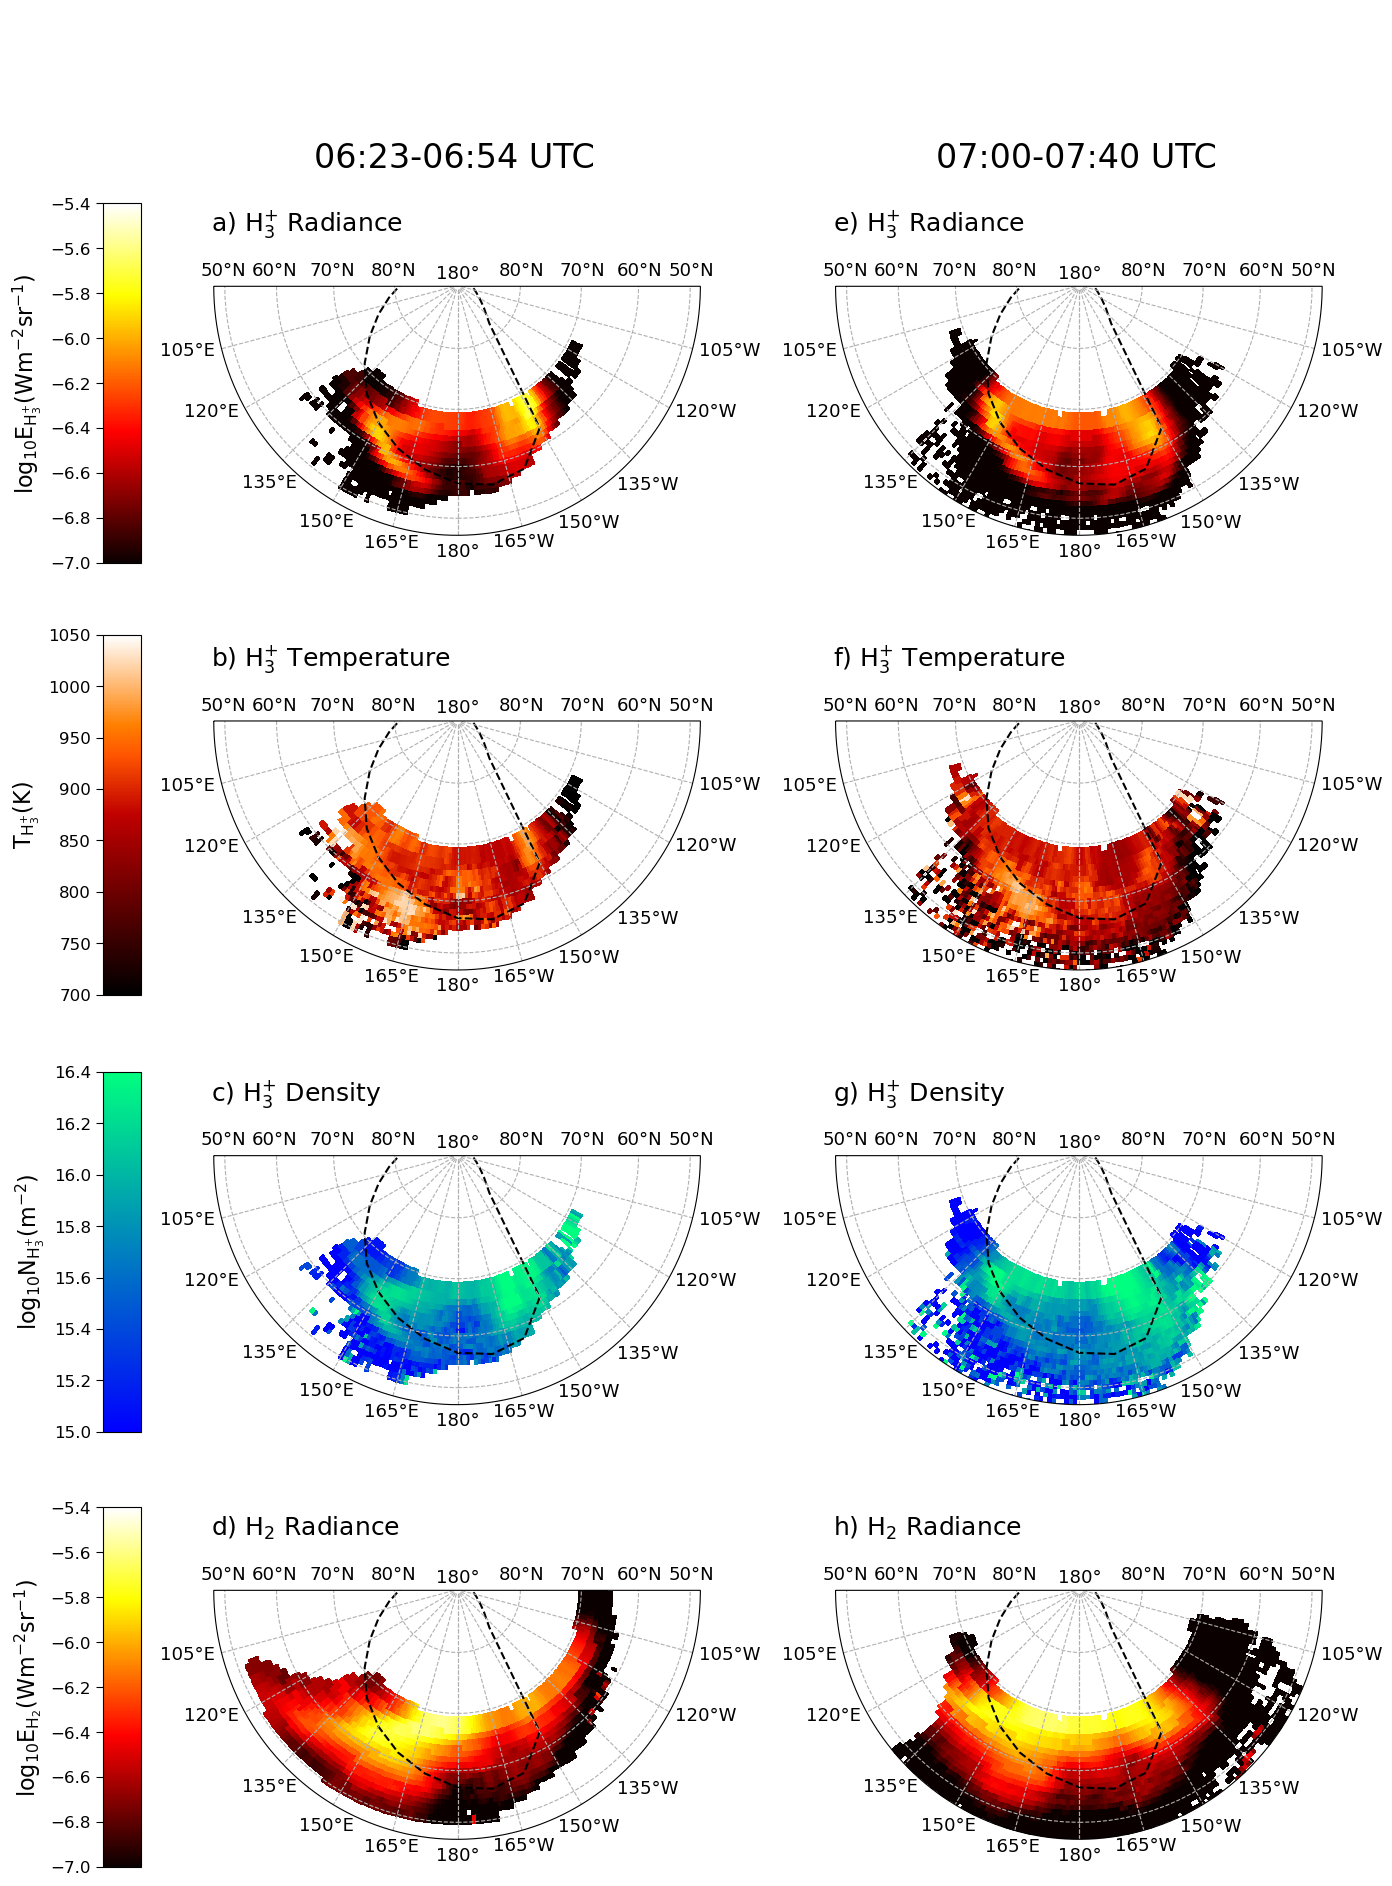

In [16]:
# from scipy.ndimage import binary_dilation

# scan1 = rolled_dens_h3p_first_scan.copy()
# scan1[rolled_dens_h3p_first_scan_errs > 2e16] = np.nan

# scan2 = rolled_dens_h3p_second_scan.copy()
# scan2[rolled_dens_h3p_second_scan_errs > 2e16] = np.nan

# scan1_thresh = np.array(scan1 > 0, dtype='float')
# scan2_thresh = np.array(scan2 > 0, dtype='float')
# # plt.imshow(binary_dilation(array_thresh)-array_thresh)

# scan1_cnt = (binary_dilation(scan1_thresh) - scan1_thresh)
# scan1_cnt_masked = np.ma.masked_where(scan1_cnt==0, scan1_cnt)

# scan2_cnt = (binary_dilation(scan2_thresh) - scan2_thresh)
# scan2_cnt_masked = np.ma.masked_where(scan2_cnt==0, scan2_cnt)

# plt.imshow(scan1_cnt_masked, cmap='hsv', interpolation='none')

# rolled_temp_h3p_first_scan[rolled_temp_h3p_first_scan < 700] = np.nan


fig = plt.figure(figsize=(15, 25))

ax1 = fig.add_subplot(4,2,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im1 = ax1.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h3p_first_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7, vmax=-5.4),
                    # extend='both',
                  )

# ax1.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl1 = ax1.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.7)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbax1 = ax1.inset_axes([-0.15, 0.0, 0.07, 0.65], transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, ax=ax1, cax=cbax1, aspect=17, orientation="vertical", location='left')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label=r'$\mathrm{log_{10} E_{H_3^{+}} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax2 = fig.add_subplot(4,2,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im2 = ax2.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h3p_second_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7, vmax=-5.4),
                   # extend='both',
                  )

# ax2.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl2 = ax2.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.7)
ax2.set_boundary(circle, transform=ax2.transAxes)
# cbar2 = plt.colorbar(im2, aspect=17, pad=-0.55, shrink=1, orientation="horizontal", location='top')
# cbar2.ax.tick_params(length=5, labelsize='large')
# cbar2.set_label(label='H$_3^{+}$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)

ax3 = fig.add_subplot(4,2,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h3p_first_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=700, vmax=1050),
                   # vmin=650, 
                   # vmax=1050, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

# ax3.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl3 = ax3.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_title('b)', fontsize=16, loc='left', y=0.6)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbax3 = ax3.inset_axes([-0.15, -0.78, 0.07, 0.65], transform=ax1.transAxes)
cbar3 = plt.colorbar(im3, ax=ax3, cax=cbax3, aspect=17, orientation="vertical", location='left')
# cbar3 = plt.colorbar(im3, aspect=17, pad=-0.55, shrink=1, orientation="vertical", location='left')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label=r'$\mathrm{T_{H_3^{+}} (K)}$', size=16, labelpad=5)

ax4 = fig.add_subplot(4,2,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h3p_second_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=700, vmax=1050),
                   # vmin=700, 
                   # vmax=1100, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

# ax4.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl4 = ax4.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
# ax4.set_title('b)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)

ax5 = fig.add_subplot(4,2,5, projection=ccrs.Orthographic(180, 90))
ax5.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax5 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax5.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax5.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im5 = ax5.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h3p_first_scan), 
                   transform=data_crs, 
                   cmap="winter", 
                   # norm=colors.LogNorm(vmin=1e15, vmax=1e17),
                     norm=colors.PowerNorm(gamma=1, vmin=15, vmax=16.4),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

# ax5.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="hot", transform=data_crs, alpha=0.7)

gl5 = ax5.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl5.xlabel_style = {'size': 13, 'color': 'k'}
gl5.ylabel_style = {'size': 13, 'color': 'k'}
# ax5.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax5.set_boundary(circle, transform=ax5.transAxes)
cbax5 = ax5.inset_axes([-0.15, -1.57, 0.07, 0.65], transform=ax1.transAxes)
cbar5 = plt.colorbar(im5, ax=ax5, cax=cbax5, aspect=17, orientation="vertical", location='left')
cbar5.ax.tick_params(length=5, labelsize='large')
cbar5.set_label(label=r'$\mathrm{log_{10} N_{H_3^{+}} (m^{-2})}$', size=16, labelpad=5)



ax6 = fig.add_subplot(4,2,6, projection=ccrs.Orthographic(180, 90))
ax6.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax6.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im6 = ax6.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h3p_second_scan), 
                   transform=data_crs, 
                   cmap="winter", 
                   # norm=colors.LogNorm(vmin=1e15, vmax=1e17),
                     norm=colors.PowerNorm(gamma=1, vmin=15, vmax=16.4),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

# ax6.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="hot", transform=data_crs, alpha=0.7)

gl6 = ax6.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl6.xlabel_style = {'size': 13, 'color': 'k'}
gl6.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax6.set_boundary(circle, transform=ax6.transAxes)



ax7 = fig.add_subplot(4,2,7, projection=ccrs.Orthographic(180, 90))
ax7.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax7.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im7 = ax7.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_first_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7, vmax=-5.4),
                    # extend='both',
                  )
gl7 = ax7.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl7.xlabel_style = {'size': 13, 'color': 'k'}
gl7.ylabel_style = {'size': 13, 'color': 'k'}
# ax7.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.7)
ax7.set_boundary(circle, transform=ax7.transAxes)
cbax7 = ax7.inset_axes([-0.15, 0, 0.07, 0.65], transform=ax7.transAxes)
cbar7 = plt.colorbar(im7, ax=ax7, cax=cbax7, aspect=17, orientation="vertical", location='left')
cbar7.ax.tick_params(length=5, labelsize='large')
cbar7.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax8 = fig.add_subplot(4,2,8, projection=ccrs.Orthographic(180, 90))
ax8.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax8.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im8 = ax8.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_second_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7, vmax=-5.4),
                   # extend='both',
                  )
gl8 = ax8.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl8.xlabel_style = {'size': 13, 'color': 'k'}
gl8.ylabel_style = {'size': 13, 'color': 'k'}
# ax8.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.7)
ax8.set_boundary(circle, transform=ax8.transAxes)

ax1.text(0.05, 0.6, 'a) H$_3^{+}$ Radiance', transform=ax1.transAxes, fontsize=18)
ax2.text(0.05, 0.6, 'e) H$_3^{+}$ Radiance', transform=ax2.transAxes, fontsize=18)
ax3.text(0.05, 0.6, 'b) H$_3^{+}$ Temperature', transform=ax3.transAxes, fontsize=18)
ax4.text(0.05, 0.6, 'f) H$_3^{+}$ Temperature', transform=ax4.transAxes, fontsize=18)
ax5.text(0.05, 0.6, 'c) H$_3^{+}$ Density', transform=ax5.transAxes, fontsize=18)
ax6.text(0.05, 0.6, 'g) H$_3^{+}$ Density', transform=ax6.transAxes, fontsize=18)
ax7.text(0.05, 0.6, 'd) H$_2$ Radiance', transform=ax7.transAxes, fontsize=18)
ax8.text(0.05, 0.6, 'h) H$_2$ Radiance', transform=ax8.transAxes, fontsize=18)

fig.subplots_adjust(hspace=-0.3, wspace=0.15)

plt.savefig(plots_dir+'/polar_map_h3p.jpg', dpi=300, bbox_inches='tight')

img = plt.imread(plots_dir+'/polar_map_h3p.jpg')

# confirm image shape
print(img.shape)

img_cropped = img[400:, :, :]

plt.imsave(plots_dir+'/polar_map_h3p.jpg', img_cropped)

In [11]:
print(np.nanmean(rolled_radiance_h3p_first_scan)*1e6, np.nanmean(rolled_radiance_h3p_second_scan)*1e6)

0.3629069547039986 0.2778890728849019


In [13]:
print(np.nanmax(rolled_radiance_h3p_first_scan)*1e6)

2.0540036776636788


In [18]:
print(np.nanmean(rolled_radiance_h3p_first_scan)*1e6, np.nanmean(rolled_radiance_h3p_second_scan)*1e6)
# print(np.nanmedian(rolled_radiance_h3p_first_scan)*1e6, np.nanmedian(rolled_radiance_h3p_second_scan)*1e6)
print(np.nanmean(rolled_temp_h3p_first_scan), np.nanmean(rolled_temp_h3p_second_scan))
# print(np.nanmedian(rolled_temp_h3p_first_scan), np.nanmedian(rolled_temp_h3p_second_scan))
print('{:0.2E}'.format(np.nanmean(rolled_dens_h3p_first_scan)), '{:0.2E}'.format(np.nanmean(rolled_dens_h3p_second_scan)))
# print('{:0.2E}'.format(np.nanmedian(rolled_dens_h3p_first_scan)), '{:0.2E}'.format(np.nanmedian(rolled_dens_h3p_second_scan)))
print(np.nanmean(rolled_int_h2_first_scan)*1e6, np.nanmean(rolled_int_h2_second_scan)*1e6)

0.3629069547039986 0.2778890728849019
891.6826323279022 848.6141347477503
8.05E+15 7.97E+15
0.5117221498796538 0.4213183374863773


(5661, 4163, 3)


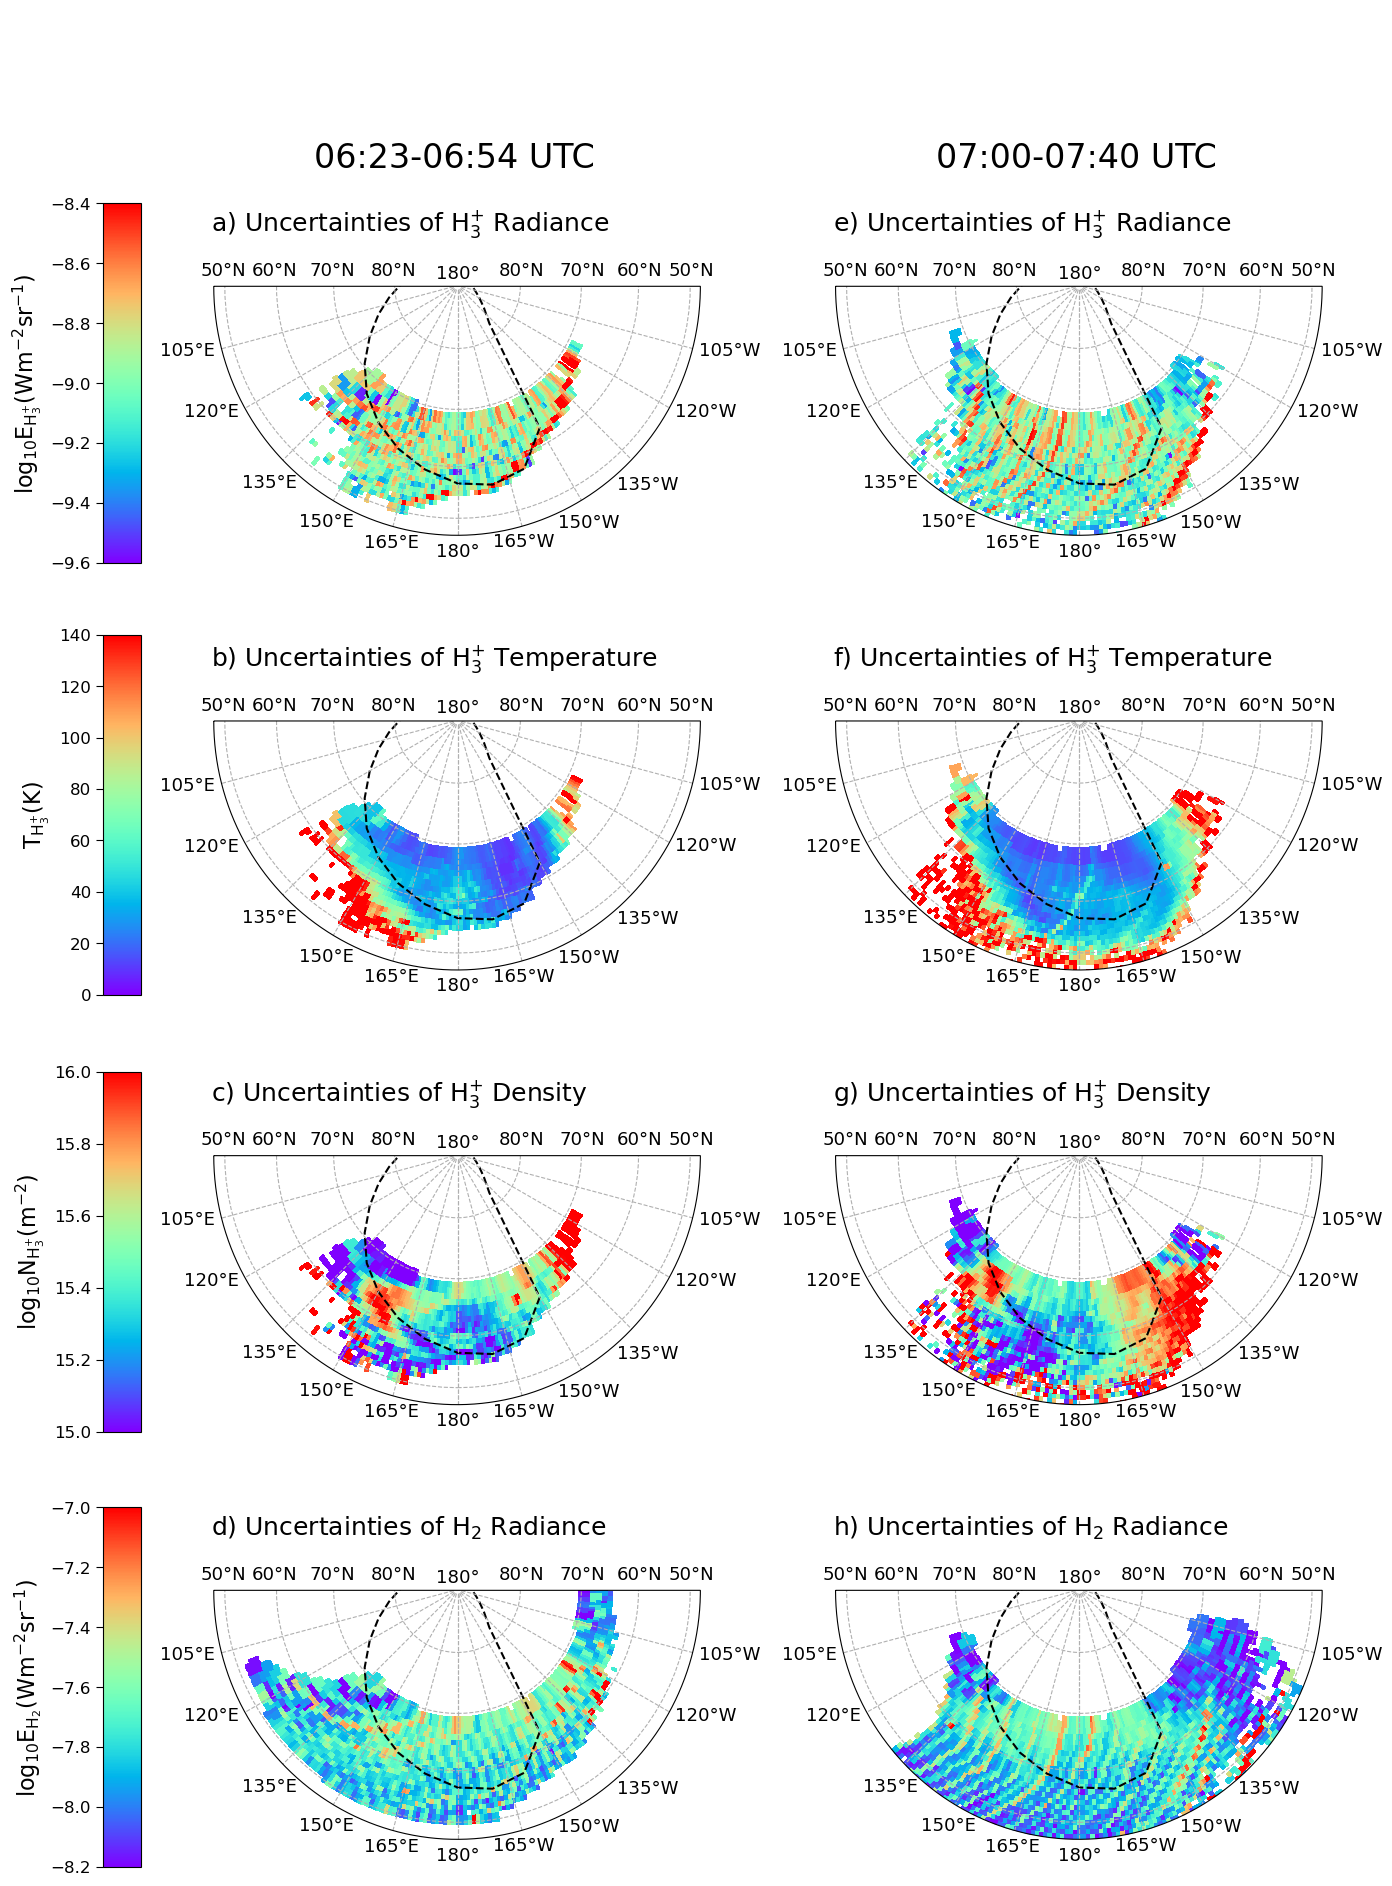

In [17]:
fig = plt.figure(figsize=(15, 25))

ax1 = fig.add_subplot(4,2,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im1 = ax1.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h3p_first_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-9.6, vmax=-8.4),
                    # extend='both',
                  )

# ax1.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl1 = ax1.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.7)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbax1 = ax1.inset_axes([-0.15, 0.0, 0.07, 0.65], transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, ax=ax1, cax=cbax1, aspect=17, orientation="vertical", location='left')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label=r'$\mathrm{log_{10} E_{H_3^{+}} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax2 = fig.add_subplot(4,2,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im2 = ax2.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h3p_second_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-9.6, vmax=-8.4),
                   # extend='both',
                  )

# ax2.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl2 = ax2.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.7)
ax2.set_boundary(circle, transform=ax2.transAxes)
# cbar2 = plt.colorbar(im2, aspect=17, pad=-0.55, shrink=1, orientation="horizontal", location='top')
# cbar2.ax.tick_params(length=5, labelsize='large')
# cbar2.set_label(label='H$_3^{+}$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)

ax3 = fig.add_subplot(4,2,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h3p_first_scan_errs, 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=0, vmax=140),
                   # vmin=650, 
                   # vmax=1050, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

# ax3.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl3 = ax3.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_title('b)', fontsize=16, loc='left', y=0.6)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbax3 = ax3.inset_axes([-0.15, -0.78, 0.07, 0.65], transform=ax1.transAxes)
cbar3 = plt.colorbar(im3, ax=ax3, cax=cbax3, aspect=17, orientation="vertical", location='left')
# cbar3 = plt.colorbar(im3, aspect=17, pad=-0.55, shrink=1, orientation="vertical", location='left')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label=r'$\mathrm{T_{H_3^{+}} (K)}$', size=16, labelpad=5)

ax4 = fig.add_subplot(4,2,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h3p_second_scan_errs, 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=0, vmax=140),
                   # vmin=700, 
                   # vmax=1100, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

# ax4.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.7)

gl4 = ax4.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
# ax4.set_title('b)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)

ax5 = fig.add_subplot(4,2,5, projection=ccrs.Orthographic(180, 90))
ax5.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax5 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax5.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax5.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im5 = ax5.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h3p_first_scan_errs), 
                   transform=data_crs, 
                   cmap="rainbow", 
                   # norm=colors.LogNorm(vmin=1e15, vmax=1e17),
                     norm=colors.PowerNorm(gamma=1, vmin=15, vmax=16),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

# ax5.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="hot", transform=data_crs, alpha=0.7)

gl5 = ax5.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl5.xlabel_style = {'size': 13, 'color': 'k'}
gl5.ylabel_style = {'size': 13, 'color': 'k'}
# ax5.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax5.set_boundary(circle, transform=ax5.transAxes)
cbax5 = ax5.inset_axes([-0.15, -1.57, 0.07, 0.65], transform=ax1.transAxes)
cbar5 = plt.colorbar(im5, ax=ax5, cax=cbax5, aspect=17, orientation="vertical", location='left')
cbar5.ax.tick_params(length=5, labelsize='large')
cbar5.set_label(label=r'$\mathrm{log_{10} N_{H_3^{+}} (m^{-2})}$', size=16, labelpad=5)



ax6 = fig.add_subplot(4,2,6, projection=ccrs.Orthographic(180, 90))
ax6.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax6.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im6 = ax6.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h3p_second_scan_errs), 
                   transform=data_crs, 
                   cmap="rainbow", 
                   # norm=colors.LogNorm(vmin=1e15, vmax=1e17),
                     norm=colors.PowerNorm(gamma=1, vmin=15, vmax=16),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

# ax6.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="hot", transform=data_crs, alpha=0.7)

gl6 = ax6.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl6.xlabel_style = {'size': 13, 'color': 'k'}
gl6.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax6.set_boundary(circle, transform=ax6.transAxes)


ax7 = fig.add_subplot(4,2,7, projection=ccrs.Orthographic(180, 90))
ax7.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax7.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im7 = ax7.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_first_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-8.2, vmax=-7.0),
                    # extend='both',
                  )
gl7 = ax7.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl7.xlabel_style = {'size': 13, 'color': 'k'}
gl7.ylabel_style = {'size': 13, 'color': 'k'}
# ax7.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.7)
ax7.set_boundary(circle, transform=ax7.transAxes)
cbax7 = ax7.inset_axes([-0.15, 0, 0.07, 0.65], transform=ax7.transAxes)
cbar7 = plt.colorbar(im7, ax=ax7, cax=cbax7, aspect=17, orientation="vertical", location='left')
cbar7.ax.tick_params(length=5, labelsize='large')
cbar7.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax8 = fig.add_subplot(4,2,8, projection=ccrs.Orthographic(180, 90))
ax8.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax8.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im8 = ax8.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_second_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-8.2, vmax=-7.0),
                   # extend='both',
                  )
gl8 = ax8.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl8.xlabel_style = {'size': 13, 'color': 'k'}
gl8.ylabel_style = {'size': 13, 'color': 'k'}
# ax8.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.7)
ax8.set_boundary(circle, transform=ax8.transAxes)


ax1.text(0.05, 0.6, 'a) Uncertainties of H$_3^{+}$ Radiance', transform=ax1.transAxes, fontsize=18)
ax2.text(0.05, 0.6, 'e) Uncertainties of H$_3^{+}$ Radiance', transform=ax2.transAxes, fontsize=18)
ax3.text(0.05, 0.6, 'b) Uncertainties of H$_3^{+}$ Temperature', transform=ax3.transAxes, fontsize=18)
ax4.text(0.05, 0.6, 'f) Uncertainties of H$_3^{+}$ Temperature', transform=ax4.transAxes, fontsize=18)
ax5.text(0.05, 0.6, 'c) Uncertainties of H$_3^{+}$ Density', transform=ax5.transAxes, fontsize=18)
ax6.text(0.05, 0.6, 'g) Uncertainties of H$_3^{+}$ Density', transform=ax6.transAxes, fontsize=18)
ax7.text(0.05, 0.6, 'd) Uncertainties of H$_2$ Radiance', transform=ax7.transAxes, fontsize=18)
ax8.text(0.05, 0.6, 'h) Uncertainties of H$_2$ Radiance', transform=ax8.transAxes, fontsize=18)

fig.subplots_adjust(hspace=-0.3, wspace=0.15)

plt.savefig(plots_dir+'/polar_map_h3p_errs.jpg', dpi=300, bbox_inches='tight')

img = plt.imread(plots_dir+'/polar_map_h3p_errs.jpg')

# confirm image shape
print(img.shape)

img_cropped = img[400:, :, :]

plt.imsave(plots_dir+'/polar_map_h3p_errs.jpg', img_cropped)

In [37]:
np.nanmean(rolled_int_h2_first_scan_errs), np.nanmean(rolled_int_h2_second_scan_errs)

(2.290684240421885e-08, 9.033376749796176e-08)

In [39]:
np.nanmean(rolled_radiance_h3p_first_scan_errs), np.nanmean(rolled_radiance_h3p_second_scan_errs)

(1.5277902141796035e-09, 1.264987082713693e-09)

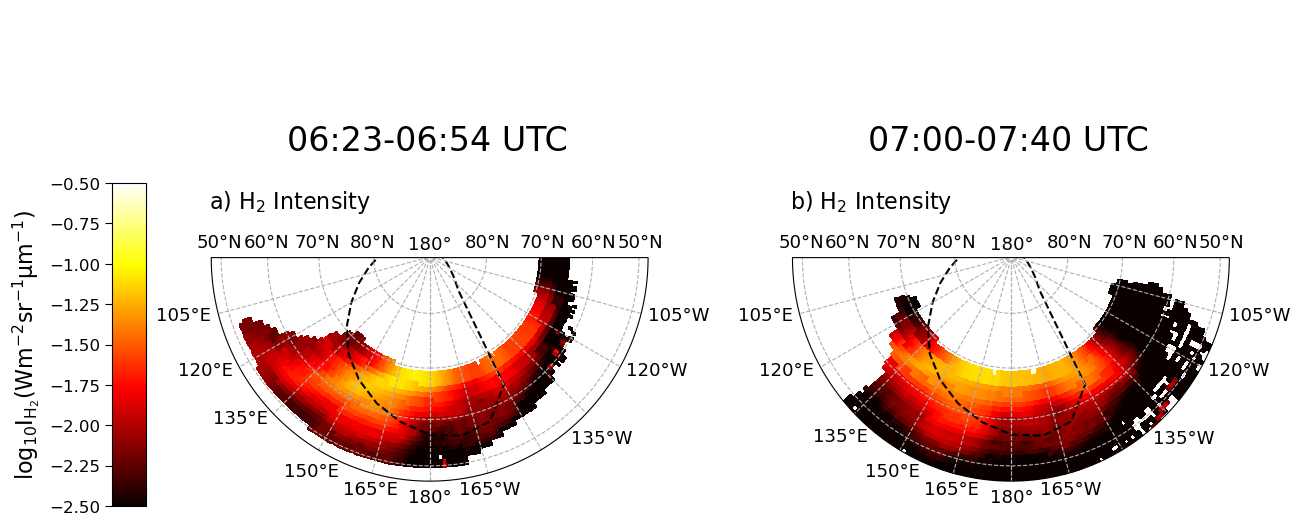

In [115]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(4,2,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im1 = ax1.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_first_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-2.5, vmax=-0.5),
                    # extend='both',
                  )
gl1 = ax1.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.7)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbax1 = ax1.inset_axes([-0.15, 0, 0.07, 0.65], transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, ax=ax1, cax=cbax1, aspect=17, orientation="vertical", location='left')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label=r'$\mathrm{log_{10} I_{H_2} (Wm^{-2}sr^{-1}\mu m^{-1})}$', size=16, labelpad=5)

ax2 = fig.add_subplot(4,2,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im2 = ax2.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_int_h2_second_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-2.5, vmax=-0.5),
                   # extend='both',
                  )
gl2 = ax2.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.7)
ax2.set_boundary(circle, transform=ax2.transAxes)

ax1.text(0.05, 0.6, 'a) H$_2$ Intensity', transform=ax1.transAxes, fontsize=16)
ax2.text(0.05, 0.6, 'b) H$_2$ Intensity', transform=ax2.transAxes, fontsize=16)

plt.subplots_adjust(hspace=-0.3, wspace=-0.4)

# plt.savefig(plots_dir+'/polar_map_h2.jpg', dpi=300, bbox_inches='tight')

# img = plt.imread(plots_dir+'/polar_map_h2.jpg')

# # confirm image shape
# print(img.shape)

# img_cropped = img[350:, :, :]

# plt.imsave(plots_dir+'/polar_map_h2.jpg', img_cropped)

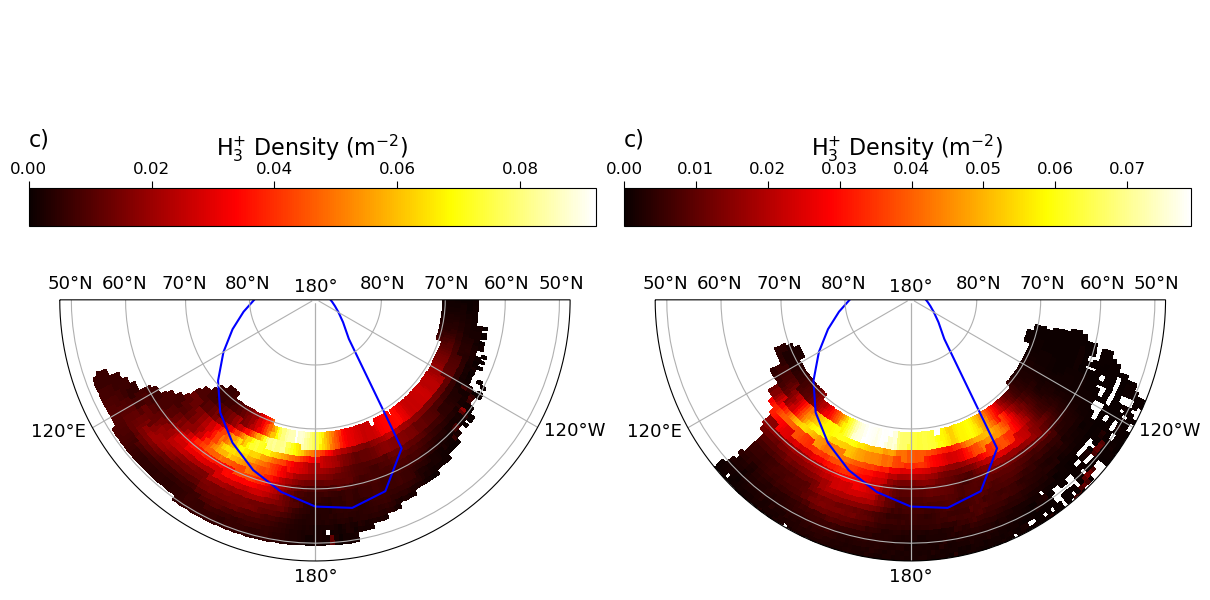

In [32]:
fig = plt.figure(figsize=(15, 15))

ax3 = fig.add_subplot(3,2,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_int_h2_first_scan, 
                   transform=data_crs, 
                   cmap="hot", 
                   # norm=colors.LogNorm(vmin=1e14, vmax=1e17),
                     # norm=colors.LogNorm(vmin=1e-1, vmax=5e-1),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )
gl3 = ax3.gridlines(draw_labels=True)
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbar3 = plt.colorbar(im3, aspect=17, pad=-0.45, shrink=1, orientation="horizontal", location='top')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label='H$_3^{+}$ Density (m$^{-2}$)', size=16, labelpad=5)

ax4 = fig.add_subplot(3,2,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_int_h2_second_scan, 
                   transform=data_crs, 
                   cmap="hot", 
                   # norm=colors.LogNorm(vmin=1e14, vmax=1e17),
                     # norm=colors.LogNorm(vmin=1e-1, vmax=5e-1),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )
gl4 = ax4.gridlines(draw_labels=True)
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
ax4.set_title('c)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)
cbar4 = plt.colorbar(im4, aspect=17, pad=-0.45, shrink=1, orientation="horizontal", location='top')
cbar4.ax.tick_params(length=5, labelsize='large')
cbar4.set_label(label='H$_3^{+}$ Density (m$^{-2}$)', size=16, labelpad=5)

plt.subplots_adjust(hspace=-0.3, wspace=0.05)

In [22]:
np.nanmax(rolled_int_h2_second_scan), np.nanmax(rolled_int_h2_first_scan)

(0.09223549502811738, 0.09223549502811738)

In [96]:
theta = np.linspace(-0.5*np.pi, -1.5*np.pi, 200)
center, radius = [0.505, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

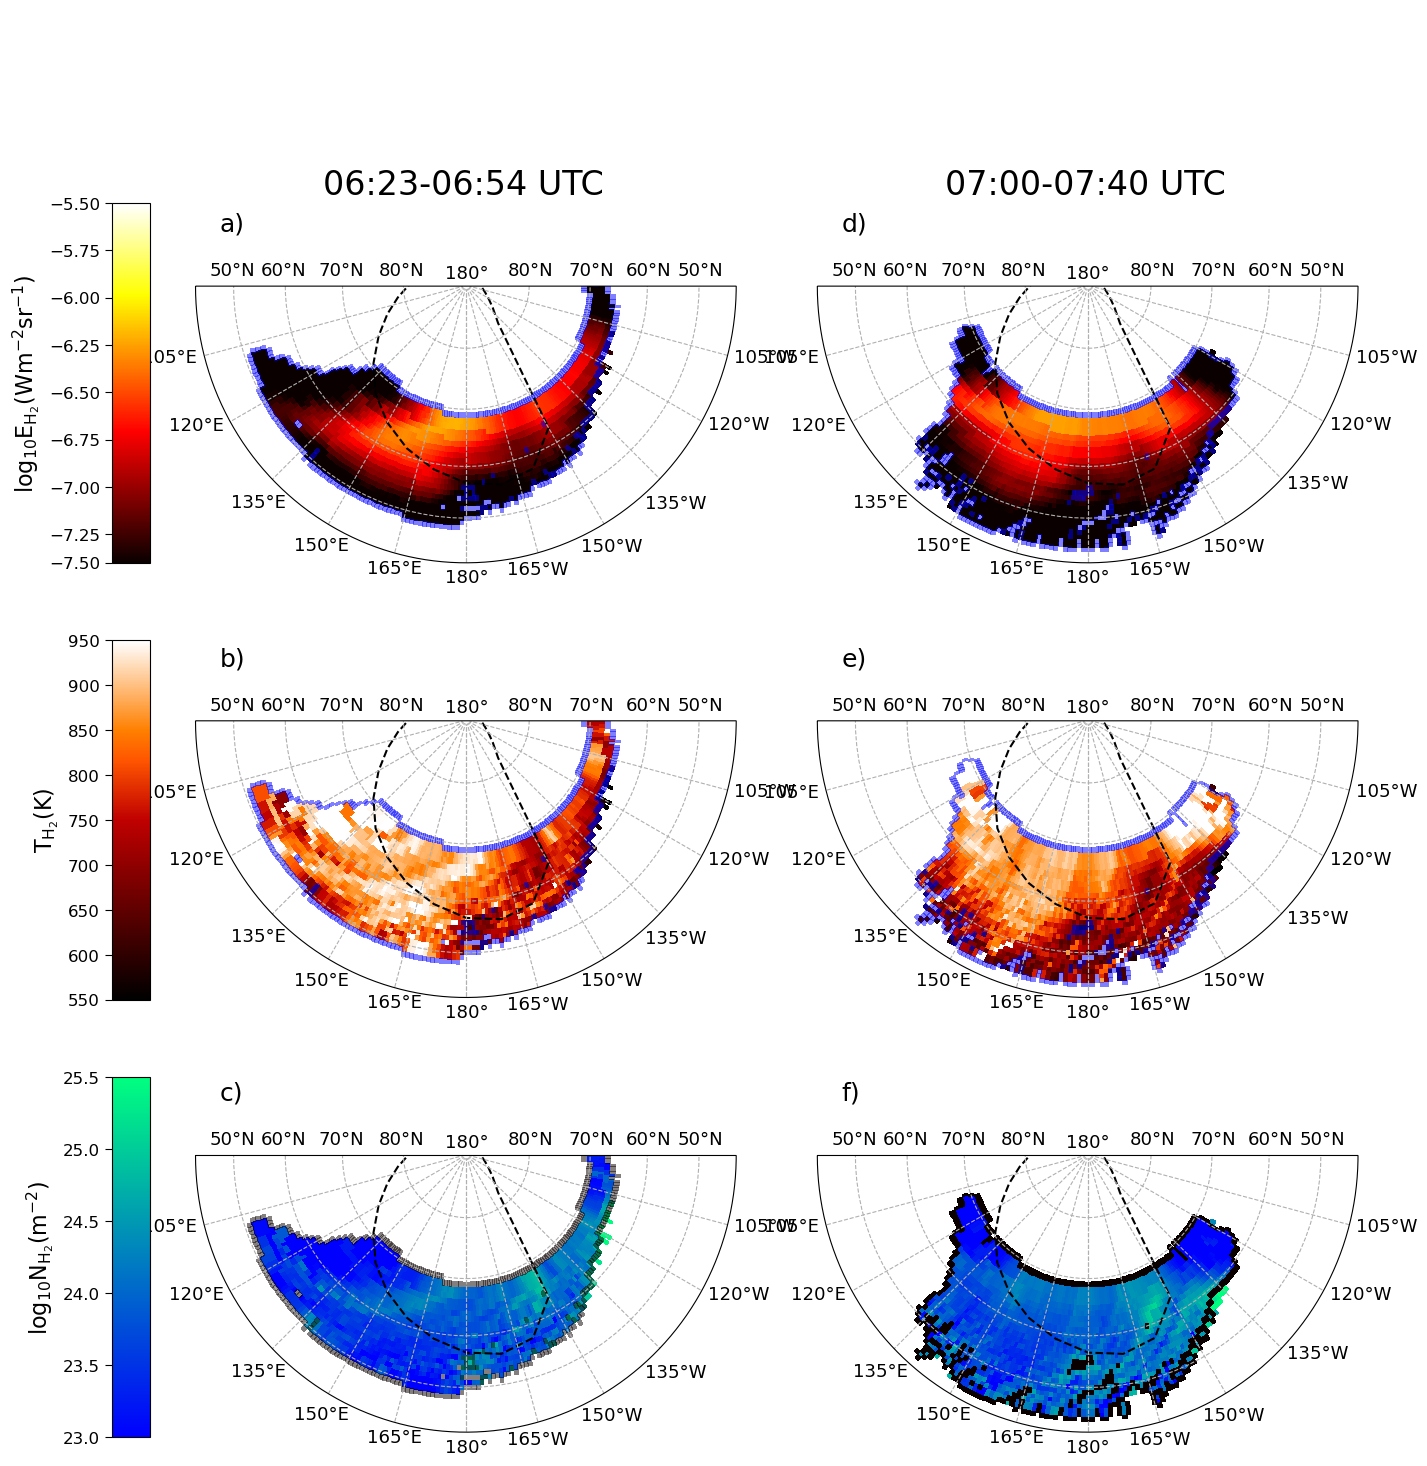

In [20]:
from scipy.ndimage import binary_dilation

scan1 = rolled_dens_h2_first_scan.copy()
scan1[rolled_dens_h2_first_scan_errs > 6e24] = np.nan

scan2 = rolled_dens_h2_second_scan.copy()
scan2[rolled_dens_h2_second_scan_errs > 6e24] = np.nan

scan1_thresh = np.array(scan1 > 0, dtype='float')
scan2_thresh = np.array(scan2 > 0, dtype='float')
# plt.imshow(binary_dilation(array_thresh)-array_thresh)

scan1_cnt = (binary_dilation(scan1_thresh) - scan1_thresh)
scan1_cnt_masked = np.ma.masked_where(scan1_cnt==0, scan1_cnt)

scan2_cnt = (binary_dilation(scan2_thresh) - scan2_thresh)
scan2_cnt_masked = np.ma.masked_where(scan2_cnt==0, scan2_cnt)

# plt.imshow(scan2_cnt_masked, cmap='hsv', interpolation='none')

fig = plt.figure(figsize=(15, 25))

ax1 = fig.add_subplot(4,2,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im1 = ax1.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h2_first_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7.4, vmax=-5.5),
                    # extend='both',
                  )

ax1.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.5)

gl1 = ax1.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.65)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbax1 = ax1.inset_axes([-0.15, 0.0, 0.07, 0.65], transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, ax=ax1, cax=cbax1, aspect=17, orientation="vertical", location='left')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax2 = fig.add_subplot(4,2,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im2 = ax2.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h2_second_scan), 
                    transform=data_crs, 
                    cmap="hot", 
                    norm=colors.PowerNorm(gamma=1, vmin=-7.4, vmax=-5.5),
                   # extend='both',
                  )

ax2.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.5)

gl2 = ax2.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.65)
ax2.set_boundary(circle, transform=ax2.transAxes)
# cbar2 = plt.colorbar(im2, aspect=17, pad=-0.55, shrink=1, orientation="horizontal", location='top')
# cbar2.ax.tick_params(length=5, labelsize='large')
# cbar2.set_label(label='H$_2$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)

ax3 = fig.add_subplot(4,2,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h2_first_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=550, vmax=950),
                   # vmin=650, 
                   # vmax=1050, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

ax3.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.5)

gl3 = ax3.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_title('b)', fontsize=16, loc='left', y=0.6)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbax3 = ax3.inset_axes([-0.15, -0.79, 0.07, 0.65], transform=ax1.transAxes)
cbar3 = plt.colorbar(im3, ax=ax3, cax=cbax3, aspect=17, orientation="vertical", location='left')
# cbar3 = plt.colorbar(im3, aspect=17, pad=-0.55, shrink=1, orientation="vertical", location='left')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label=r'$\mathrm{T_{H_2} (K)}$', size=16, labelpad=5)

ax4 = fig.add_subplot(4,2,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h2_second_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=550, vmax=950),
                   # vmin=700, 
                   # vmax=1100, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )

ax4.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="bwr", transform=data_crs, alpha=0.5)

gl4 = ax4.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
# ax4.set_title('b)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)

ax5 = fig.add_subplot(4,2,5, projection=ccrs.Orthographic(180, 90))
ax5.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax5 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax5.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax5.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im5 = ax5.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h2_first_scan), 
                   transform=data_crs, 
                   cmap="winter", 
                   norm=colors.PowerNorm(gamma=1, vmin=23, vmax=25.5),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

ax5.pcolormesh(360 - lon, lat, scan1_cnt_masked, cmap="hot", transform=data_crs, alpha=0.5)

gl5 = ax5.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl5.xlabel_style = {'size': 13, 'color': 'k'}
gl5.ylabel_style = {'size': 13, 'color': 'k'}
# ax5.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax5.set_boundary(circle, transform=ax5.transAxes)
cbax5 = ax5.inset_axes([-0.15, -1.58, 0.07, 0.65], transform=ax1.transAxes)
cbar5 = plt.colorbar(im5, ax=ax5, cax=cbax5, aspect=17, orientation="vertical", location='left')
cbar5.ax.tick_params(length=5, labelsize='large')
cbar5.set_label(label=r'$\mathrm{log_{10} N_{H_2} (m^{-2})}$', size=16, labelpad=5)

ax6 = fig.add_subplot(4,2,6, projection=ccrs.Orthographic(180, 90))
ax6.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax6.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im6 = ax6.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h2_second_scan), 
                   transform=data_crs, 
                   cmap="winter", 
                   norm=colors.PowerNorm(gamma=1, vmin=23, vmax=25.5),
                   # vmin=5e24, 
                   # vmax=1e27, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )

ax6.pcolormesh(360 - lon, lat, scan2_cnt_masked, cmap="hot", transform=data_crs, alpha=1)

gl6 = ax6.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl6.xlabel_style = {'size': 13, 'color': 'k'}
gl6.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax6.set_boundary(circle, transform=ax6.transAxes)

ax1.text(0.05, 0.6, 'a)', transform=ax1.transAxes, fontsize=18)
ax2.text(0.05, 0.6, 'd)', transform=ax2.transAxes, fontsize=18)
ax3.text(0.05, 0.6, 'b)', transform=ax3.transAxes, fontsize=18)
ax4.text(0.05, 0.6, 'e)', transform=ax4.transAxes, fontsize=18)
ax5.text(0.05, 0.6, 'c)', transform=ax5.transAxes, fontsize=18)
ax6.text(0.05, 0.6, 'f)', transform=ax6.transAxes, fontsize=18)

plt.subplots_adjust(hspace=-0.3, wspace=0.15)
# plt.savefig(plots_dir+'/polar_map_h2.jpg', dpi=400, bbox_inches='tight', facecolor='white')

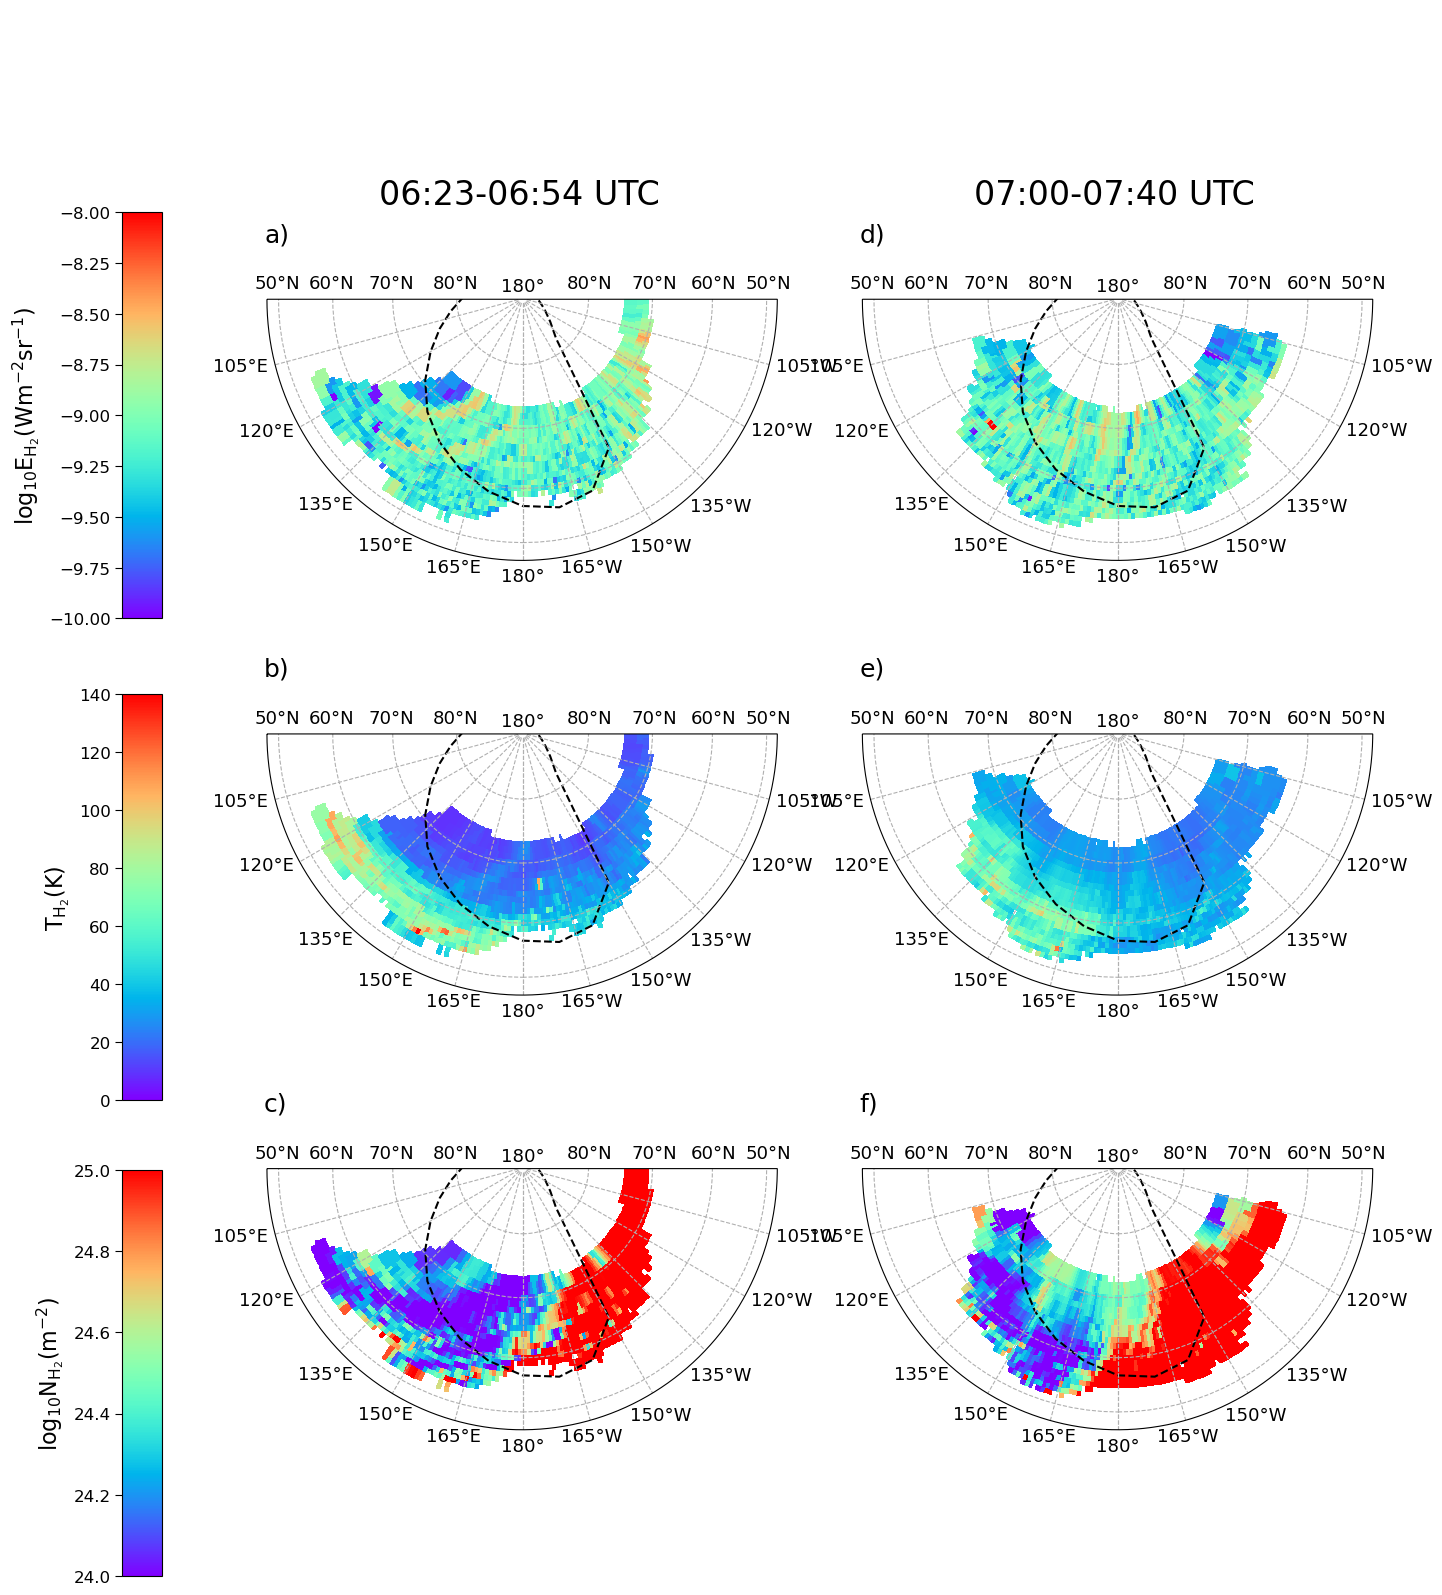

In [31]:
fig = plt.figure(figsize=(15, 25))

ax1 = fig.add_subplot(4,2,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im1 = ax1.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h2_first_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-10, vmax=-8),
                    # extend='both',
                  )
gl1 = ax1.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('06:23-06:54 UTC', fontsize=24, loc='center', y=0.65)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbax1 = ax1.inset_axes([-0.2, -0.05, 0.07, 0.7], transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, ax=ax1, cax=cbax1, aspect=17, orientation="vertical", location='left')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax2 = fig.add_subplot(4,2,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im2 = ax2.pcolormesh(360 - lon, 
                    lat, 
                    np.log10(rolled_radiance_h2_second_scan_errs), 
                    transform=data_crs, 
                    cmap="rainbow", 
                    norm=colors.PowerNorm(gamma=1, vmin=-10, vmax=-8),
                   # extend='both',
                  )
gl2 = ax2.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('07:00-07:40 UTC', fontsize=24, loc='center', y=0.65)
ax2.set_boundary(circle, transform=ax2.transAxes)
# cbar2 = plt.colorbar(im2, aspect=17, pad=-0.55, shrink=1, orientation="horizontal", location='top')
# cbar2.ax.tick_params(length=5, labelsize='large')
# cbar2.set_label(label='H$_2$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)

ax3 = fig.add_subplot(4,2,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h2_first_scan_errs, 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=0, vmax=140),
                   # vmin=650, 
                   # vmax=1050, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )
gl3 = ax3.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_title('b)', fontsize=16, loc='left', y=0.6)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbax3 = ax3.inset_axes([-0.2, -0.88, 0.07, 0.7], transform=ax1.transAxes)
cbar3 = plt.colorbar(im3, ax=ax3, cax=cbax3, aspect=17, orientation="vertical", location='left')
# cbar3 = plt.colorbar(im3, aspect=17, pad=-0.55, shrink=1, orientation="vertical", location='left')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label=r'$\mathrm{T_{H_2} (K)}$', size=16, labelpad=5)

ax4 = fig.add_subplot(4,2,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h2_second_scan_errs, 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=0, vmax=140),
                   # vmin=700, 
                   # vmax=1100, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )
gl4 = ax4.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
# ax4.set_title('b)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)

ax5 = fig.add_subplot(4,2,5, projection=ccrs.Orthographic(180, 90))
ax5.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax5 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax5.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax5.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im5 = ax5.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h2_first_scan_errs), 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=24, vmax=25),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )
gl5 = ax5.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl5.xlabel_style = {'size': 13, 'color': 'k'}
gl5.ylabel_style = {'size': 13, 'color': 'k'}
# ax5.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax5.set_boundary(circle, transform=ax5.transAxes)
cbax5 = ax5.inset_axes([-0.2, -1.7, 0.07, 0.7], transform=ax1.transAxes)
cbar5 = plt.colorbar(im5, ax=ax5, cax=cbax5, aspect=17, orientation="vertical", location='left')
cbar5.ax.tick_params(length=5, labelsize='large')
cbar5.set_label(label=r'$\mathrm{log_{10} N_{H_2} (m^{-2})}$', size=16, labelpad=5)

ax6 = fig.add_subplot(4,2,6, projection=ccrs.Orthographic(180, 90))
ax6.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax6.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="k", ls="--")
im6 = ax6.pcolormesh(360 - lon, 
                   lat, 
                   np.log10(rolled_dens_h2_second_scan_errs), 
                   transform=data_crs, 
                   cmap="rainbow", 
                   norm=colors.PowerNorm(gamma=1, vmin=24, vmax=25),
                   # vmin=5e24, 
                   # vmax=1e27, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )
gl6 = ax6.gridlines(draw_labels=True, xlocs=longlocs, linestyle='--')
gl6.xlabel_style = {'size': 13, 'color': 'k'}
gl6.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
# ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax6.set_boundary(circle, transform=ax6.transAxes)

ax1.text(0.05, 0.6, 'a)', transform=ax1.transAxes, fontsize=18)
ax2.text(0.05, 0.6, 'd)', transform=ax2.transAxes, fontsize=18)
ax3.text(0.05, 0.6, 'b)', transform=ax3.transAxes, fontsize=18)
ax4.text(0.05, 0.6, 'e)', transform=ax4.transAxes, fontsize=18)
ax5.text(0.05, 0.6, 'c)', transform=ax5.transAxes, fontsize=18)
ax6.text(0.05, 0.6, 'f)', transform=ax6.transAxes, fontsize=18)

plt.subplots_adjust(hspace=-0.3, wspace=0.05)
# plt.savefig(plots_dir+'/polar_map_h2_errs.jpg', dpi=400, bbox_inches='tight', facecolor='white')

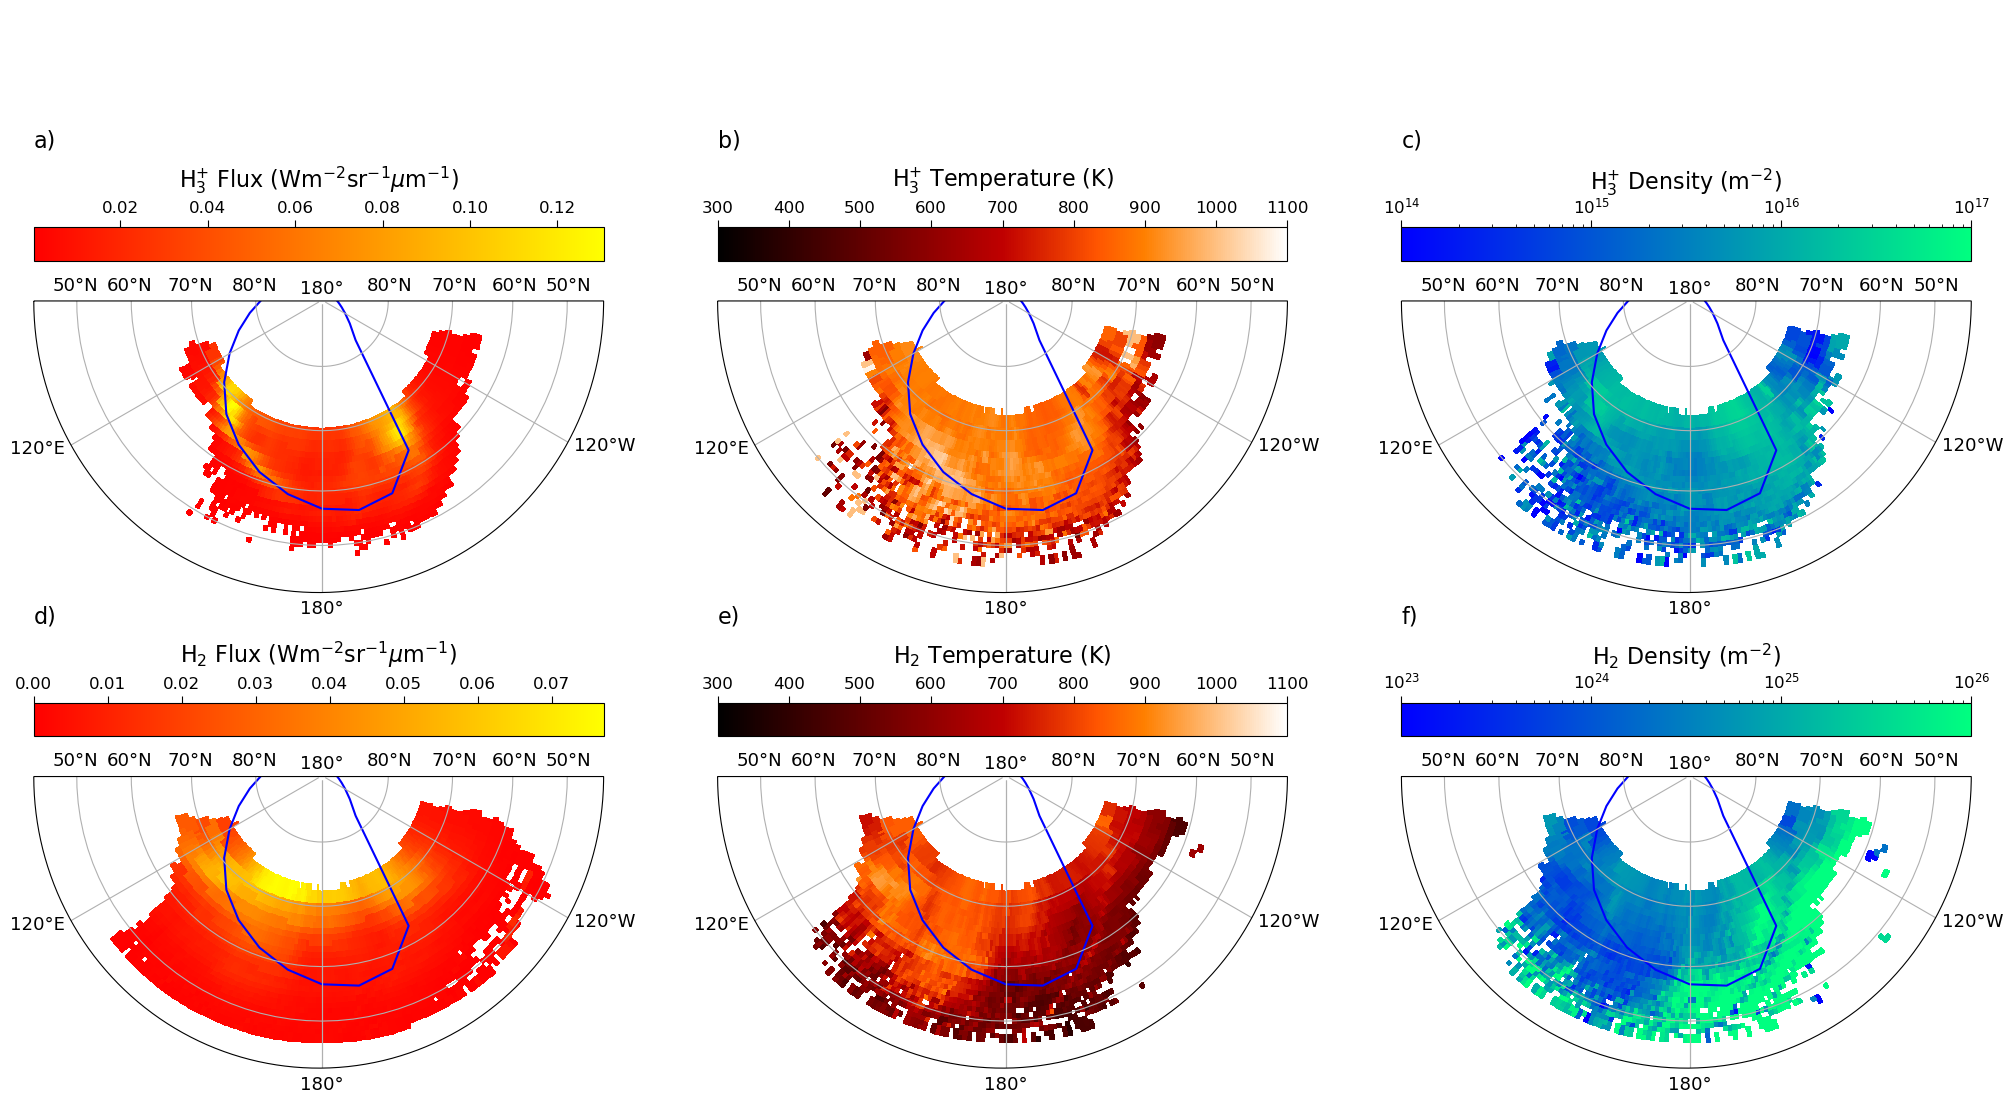

In [27]:
fig = plt.figure(figsize=(25, 15))

ax1 = fig.add_subplot(2,3,1, projection=ccrs.Orthographic(180, 90))
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax1.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im1 = ax1.pcolormesh(360 - lon, 
                   lat, 
                   rolled_int_h3p_second_scan, 
                   transform=data_crs, 
                   cmap="autumn", 
                   # extend='both',
                  )
gl1 = ax1.gridlines(draw_labels=True)
gl1.xlabel_style = {'size': 13, 'color': 'k'}
gl1.ylabel_style = {'size': 13, 'color': 'k'}
ax1.set_title('a)', fontsize=16, loc='left', y=0.75)
ax1.set_boundary(circle, transform=ax1.transAxes)
cbar1 = plt.colorbar(im1, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label='H$_3^{+}$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)


ax2 = fig.add_subplot(2,3,2, projection=ccrs.Orthographic(180, 90))
ax2.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax2.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im2 = ax2.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h3p_second_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=300, vmax=1100),
                    # norm=colors.PowerNorm(gamma=1), 
                   # vmin=700, 
                   # vmax=1100, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )
gl2 = ax2.gridlines(draw_labels=True)
gl2.xlabel_style = {'size': 13, 'color': 'k'}
gl2.ylabel_style = {'size': 13, 'color': 'k'}
ax2.set_title('b)', fontsize=16, loc='left', y=0.75)
ax2.set_boundary(circle, transform=ax2.transAxes)
cbar2 = plt.colorbar(im2, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='H$_3^{+}$ Temperature (K)', size=16, labelpad=10)


ax3 = fig.add_subplot(2,3,3, projection=ccrs.Orthographic(180, 90))
ax3.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
# ax3 = plt.subplot(122, projection=ccrs.Orthographic(180, 90))
# ax3.imshow(rolled_map, interpolation='none', origin='lower', extent=[0,360,-90,90], cmap='gist_heat')
ax3.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im3 = ax3.pcolormesh(360 - lon, 
                   lat, 
                   rolled_dens_h3p_second_scan, 
                   transform=data_crs, 
                   cmap="winter", 
                   norm=colors.LogNorm(vmin=1e14, vmax=1e17),
                   # vmin=5e14, 
                   # vmax=1e17, 
                   # levels=np.linspace(5e14, 1e17, 6),
                   # extend='both',
                  )
gl3 = ax3.gridlines(draw_labels=True)
gl3.xlabel_style = {'size': 13, 'color': 'k'}
gl3.ylabel_style = {'size': 13, 'color': 'k'}
# ax3.set_global()
ax3.set_title('c)', fontsize=16, loc='left', y=0.75)
ax3.set_boundary(circle, transform=ax3.transAxes)
cbar3 = plt.colorbar(im3, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label='H$_3^{+}$ Density (m$^{-2}$)', size=16, labelpad=5)


ax4 = fig.add_subplot(2,3,4, projection=ccrs.Orthographic(180, 90))
ax4.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax4.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im4 = ax4.pcolormesh(360 - lon, 
                   lat, 
                   rolled_int_h2_second_scan, 
                   transform=data_crs, 
                   cmap="autumn", 
                   # extend='both',
                  )
gl4 = ax4.gridlines(draw_labels=True)
gl4.xlabel_style = {'size': 13, 'color': 'k'}
gl4.ylabel_style = {'size': 13, 'color': 'k'}
ax4.set_title('d)', fontsize=16, loc='left', y=0.75)
ax4.set_boundary(circle, transform=ax4.transAxes)
cbar4 = plt.colorbar(im4, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar4.ax.tick_params(length=5, labelsize='large')
cbar4.set_label(label='H$_2$ Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16, labelpad=10)


ax5 = fig.add_subplot(2,3,5, projection=ccrs.Orthographic(180, 90))
ax5.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax5.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im5 = ax5.pcolormesh(360 - lon, 
                   lat, 
                   rolled_temp_h2_second_scan, 
                   transform=data_crs, 
                   cmap="gist_heat", 
                   norm=colors.PowerNorm(gamma=1, vmin=300, vmax=1100),
                     # norm=colors.PowerNorm(gamma=1),
                   # vmin=400, 
                   # vmax=1000, 
                   # levels=np.linspace(700, 1100, 8), 
                   # extend='both',
                  )
gl5 = ax5.gridlines(draw_labels=True)
gl5.xlabel_style = {'size': 13, 'color': 'k'}
gl5.ylabel_style = {'size': 13, 'color': 'k'}
ax5.set_title('e)', fontsize=16, loc='left', y=0.75)
ax5.set_boundary(circle, transform=ax5.transAxes)
cbar5 = plt.colorbar(im5, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar5.ax.tick_params(length=5, labelsize='large')
cbar5.set_label(label='H$_2$ Temperature (K)', size=16, labelpad=10)


ax6 = fig.add_subplot(2,3,6, projection=ccrs.Orthographic(180, 90))
ax6.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
ax6.plot(360 - main_oval_long, main_oval_lat, transform=data_crs, c="b", ls="-")
im6 = ax6.pcolormesh(360 - lon, 
                   lat, 
                   rolled_dens_h2_second_scan, 
                   transform=data_crs, 
                   cmap="winter", 
                   norm=colors.LogNorm(vmin=1e23, vmax=1e26),
                   # vmin=1e23, 
                   # vmax=1e27, 
                   # levels=np.linspace(1e23, 1e27, 8),
                   # extend='both',
                  )
gl6 = ax6.gridlines(draw_labels=True)
gl6.xlabel_style = {'size': 13, 'color': 'k'}
gl6.ylabel_style = {'size': 13, 'color': 'k'}
ax6.set_title('f)', fontsize=16, loc='left', y=0.75)
ax6.set_boundary(circle, transform=ax6.transAxes)
cbar6 = plt.colorbar(im6, aspect=17, pad=-0.37, shrink=1, orientation="horizontal", location='top')
cbar6.ax.tick_params(length=5, labelsize='large')
cbar6.set_label(label='H$_2$ Density (m$^{-2}$)', size=16, labelpad=5)

# plt.tight_layout()
plt.subplots_adjust(hspace=-0.3)
plt.savefig(plots_dir+'/polar_map_second_scan.jpg', dpi=400, bbox_inches='tight', facecolor='white')

# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0)
# plt.margins(0,0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

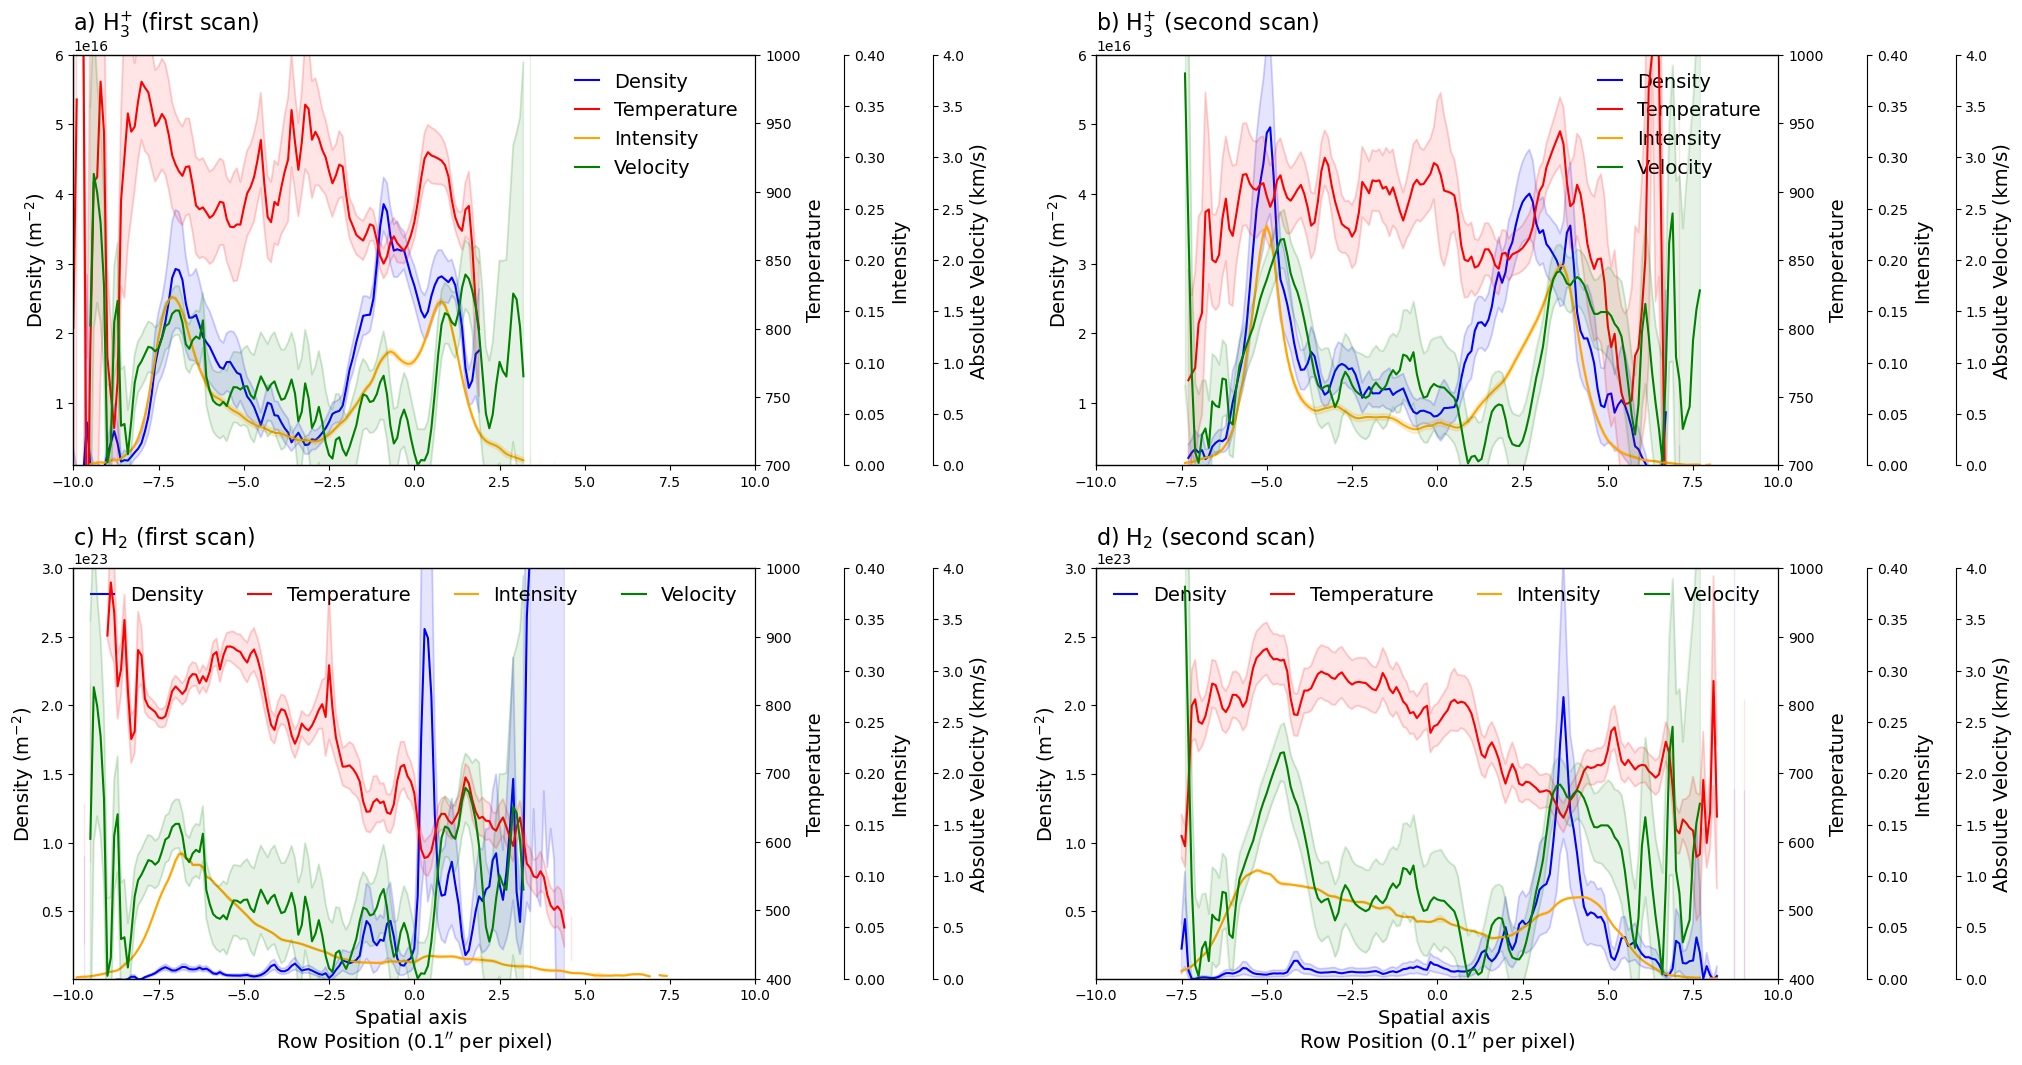

In [7]:
xnew = np.linspace(-15,15,301)

fig = plt.figure(figsize=(22, 12))

i = 3

ax1 = fig.add_subplot(2,2,1)

bri = h3p_int_v2[i]
bri_err = h3p_int_err_v2[i]

temp = h3p_temp[i]
temp_errs = h3p_temp_errs[i]

dens = h3p_dens[i]
dens_errs = h3p_dens_errs[i]

flow = np.abs(h2_h3p_flow[i])
flow_errs = h2_h3p_flow_errs[i]

dmax = dens + dens_errs
dmin = dens - dens_errs

tmax = temp + temp_errs
tmin = temp - temp_errs

fmax = flow + flow_errs
fmin = flow - flow_errs

bmax = bri + bri_err
bmin = bri - bri_err

ax1.plot(xnew, dens, color='blue', label='Density')
ax1.plot(xnew, dmax, color='blue', alpha=0.1)
ax1.plot(xnew, dmin, color='blue', alpha=0.1)
ax1.fill_between(xnew, dmin, dmax, color='b', alpha=0.1)
# ax1.set_xlabel('Spatial axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
ax1.set_ylabel('Density (m$^{-2}$)', fontsize=14)
ax1.set_ylim(1e15,6e16)
ax1.set_xlim(-10,10)
ax1.set_title('a) H$_3^{+}$ (first scan)', loc='left', fontsize=16)

ax1a = ax1.twinx()

ax1a.plot(xnew, temp, color='red', label='Temperature')
ax1a.plot(xnew, tmax, color='red', alpha=0.1)
ax1a.plot(xnew, tmin, color='red', alpha=0.1)
ax1a.fill_between(xnew, tmin, tmax, color='red', alpha=0.1)
ax1a.set_ylabel('Temperature', fontsize=14)
ax1a.set_ylim(700,1000)

ax1b = ax1.twinx()
ax1b.spines.right.set_position(('axes', 1.13))

ax1b.plot(xnew, bri, color='orange', label='Intensity')
ax1b.plot(xnew, bmax, color='orange', alpha=0.1)
ax1b.plot(xnew, bmin, color='orange', alpha=0.1)
ax1b.fill_between(xnew, bmin, bmax, color='orange', alpha=0.1)
ax1b.set_ylabel('Intensity', fontsize=14)
ax1b.set_ylim(0,0.4)

ax1c = ax1.twinx()
ax1c.spines.right.set_position(("axes", 1.26))

ax1c.plot(xnew, flow, color='green', label='Velocity')
ax1c.plot(xnew, fmax, color='green', alpha=0.1)
ax1c.plot(xnew, fmin, color='green', alpha=0.1)
ax1c.fill_between(xnew, fmin, fmax, color='green', alpha=0.1)
ax1c.set_ylabel('Absolute Velocity (km/s)', fontsize=14)
ax1c.set_ylim(0,4)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1a.get_legend_handles_labels()
lines3, labels3 = ax1b.get_legend_handles_labels()
lines4, labels4 = ax1c.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3 + lines4, 
           labels + labels2 + labels3 + labels4, 
           loc='upper right', 
#            ncols=3, 
#            mode='expand', 
           handlelength=1.2, 
           frameon=False, 
           fontsize=14,
          )

i = 18

bri = h3p_int_v2[i]
bri_err = h3p_int_err_v2[i]

temp = h3p_temp[i]
temp_errs = h3p_temp_errs[i]

dens = h3p_dens[i]
dens_errs = h3p_dens_errs[i]

flow = np.abs(h2_h3p_flow[i])
flow_errs = h2_h3p_flow_errs[i]

dmax = dens + dens_errs
dmin = dens - dens_errs

tmax = temp + temp_errs
tmin = temp - temp_errs

fmax = flow + flow_errs
fmin = flow - flow_errs

bmax = bri + bri_err
bmin = bri - bri_err

ax2 = fig.add_subplot(2,2,2)

ax2.plot(xnew, dens, color='blue', label='Density')
ax2.plot(xnew, dmax, color='blue', alpha=0.1)
ax2.plot(xnew, dmin, color='blue', alpha=0.1)
ax2.fill_between(xnew, dmin, dmax, color='b', alpha=0.1)
# ax2.set_xlabel('Spatial axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
ax2.set_ylabel('Density (m$^{-2}$)', fontsize=14)
ax2.set_ylim(1e15,6e16)
ax2.set_xlim(-10,10)
ax2.set_title('b) H$_3^{+}$ (second scan)', loc='left', fontsize=16)

ax2a = ax2.twinx()

ax2a.plot(xnew, temp, color='red', label='Temperature')
ax2a.plot(xnew, tmax, color='red', alpha=0.1)
ax2a.plot(xnew, tmin, color='red', alpha=0.1)
ax2a.fill_between(xnew, tmin, tmax, color='red', alpha=0.1)
ax2a.set_ylabel('Temperature', fontsize=14)
ax2a.set_ylim(700,1000)

ax2b = ax2.twinx()
ax2b.spines.right.set_position(('axes', 1.13))

ax2b.plot(xnew, bri, color='orange', label='Intensity')
ax2b.plot(xnew, bmax, color='orange', alpha=0.1)
ax2b.plot(xnew, bmin, color='orange', alpha=0.1)
ax2b.fill_between(xnew, bmin, bmax, color='orange', alpha=0.1)
ax2b.set_ylabel('Intensity', fontsize=14)
ax2b.set_ylim(0,0.4)

ax2c = ax2.twinx()
ax2c.spines.right.set_position(("axes", 1.26))

ax2c.plot(xnew, flow, color='green', label='Velocity')
ax2c.plot(xnew, fmax, color='green', alpha=0.1)
ax2c.plot(xnew, fmin, color='green', alpha=0.1)
ax2c.fill_between(xnew, fmin, fmax, color='green', alpha=0.1)
ax2c.set_ylabel('Absolute Velocity (km/s)', fontsize=14)
ax2c.set_ylim(0,4)

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2a.get_legend_handles_labels()
lines3, labels3 = ax2b.get_legend_handles_labels()
lines4, labels4 = ax2c.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3 + lines4, 
           labels + labels2 + labels3 + labels4, 
           loc='upper right', 
#            ncols=3, 
#            mode='expand', 
           handlelength=1.2, 
           frameon=False, 
           fontsize=14,
          )

i = 3

ax3 = fig.add_subplot(2,2,3)

bri = h2_int_v2[i]
bri_err = h2_int_err_v2[i]

temp = h2_temp[i]
temp_errs = h2_temp_errs[i]

dens = h2_dens[i]
dens_errs = h2_dens_errs[i]

flow = np.abs(h2_h3p_flow[i])
flow_errs = h2_h3p_flow_errs[i]

dmax = dens + dens_errs
dmin = dens - dens_errs

tmax = temp + temp_errs
tmin = temp - temp_errs

fmax = flow + flow_errs
fmin = flow - flow_errs

bmax = bri + bri_err
bmin = bri - bri_err

ax3.plot(xnew, dens, color='blue', label='Density')
ax3.plot(xnew, dmax, color='blue', alpha=0.1)
ax3.plot(xnew, dmin, color='blue', alpha=0.1)
ax3.fill_between(xnew, dmin, dmax, color='b', alpha=0.1)
ax3.set_xlabel('Spatial axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
ax3.set_ylabel('Density (m$^{-2}$)', fontsize=14)
ax3.set_ylim(1e21,3e23)
ax3.set_xlim(-10,10)
ax3.set_title('c) H$_2$ (first scan)', loc='left', fontsize=16)

ax3a = ax3.twinx()

ax3a.plot(xnew, temp, color='red', label='Temperature')
ax3a.plot(xnew, tmax, color='red', alpha=0.1)
ax3a.plot(xnew, tmin, color='red', alpha=0.1)
ax3a.fill_between(xnew, tmin, tmax, color='red', alpha=0.1)
ax3a.set_ylabel('Temperature', fontsize=14)
ax3a.set_ylim(400,1000)

ax3b = ax3.twinx()
ax3b.spines.right.set_position(('axes', 1.13))

ax3b.plot(xnew, bri, color='orange', label='Intensity')
ax3b.plot(xnew, bmax, color='orange', alpha=0.1)
ax3b.plot(xnew, bmin, color='orange', alpha=0.1)
ax3b.fill_between(xnew, bmin, bmax, color='orange', alpha=0.1)
ax3b.set_ylabel('Intensity', fontsize=14)
ax3b.set_ylim(0,0.4)

ax3c = ax3.twinx()
ax3c.spines.right.set_position(("axes", 1.26))

ax3c.plot(xnew, flow, color='green', label='Velocity')
ax3c.plot(xnew, fmax, color='green', alpha=0.1)
ax3c.plot(xnew, fmin, color='green', alpha=0.1)
ax3c.fill_between(xnew, fmin, fmax, color='green', alpha=0.1)
ax3c.set_ylabel('Absolute Velocity (km/s)', fontsize=14)
ax3c.set_ylim(0,4)

lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3a.get_legend_handles_labels()
lines3, labels3 = ax3b.get_legend_handles_labels()
lines4, labels4 = ax3c.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3 + lines4, 
           labels + labels2 + labels3 + labels4, 
           loc='upper center', 
           ncols=4, 
           mode='expand', 
           handlelength=1.2, 
           frameon=False, 
           fontsize=14,
          )

i = 18

bri = h2_int_v2[i]
bri_err = h2_int_err_v2[i]

temp = h2_temp[i]
temp_errs = h2_temp_errs[i]

dens = h2_dens[i]
dens_errs = h2_dens_errs[i]

flow = np.abs(h2_h3p_flow[i])
flow_errs = h2_h3p_flow_errs[i]

dmax = dens + dens_errs
dmin = dens - dens_errs

tmax = temp + temp_errs
tmin = temp - temp_errs

fmax = flow + flow_errs
fmin = flow - flow_errs

bmax = bri + bri_err
bmin = bri - bri_err

ax4 = fig.add_subplot(2,2,4)

ax4.plot(xnew, dens, color='blue', label='Density')
ax4.plot(xnew, dmax, color='blue', alpha=0.1)
ax4.plot(xnew, dmin, color='blue', alpha=0.1)
ax4.fill_between(xnew, dmin, dmax, color='b', alpha=0.1)
ax4.set_xlabel('Spatial axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=14)
ax4.set_ylabel('Density (m$^{-2}$)', fontsize=14)
ax4.set_ylim(1e21,3e23)
ax4.set_xlim(-10,10)
ax4.set_title('d) H$_2$ (second scan)', loc='left', fontsize=16)

ax4a = ax4.twinx()

ax4a.plot(xnew, temp, color='red', label='Temperature')
ax4a.plot(xnew, tmax, color='red', alpha=0.1)
ax4a.plot(xnew, tmin, color='red', alpha=0.1)
ax4a.fill_between(xnew, tmin, tmax, color='red', alpha=0.1)
ax4a.set_ylabel('Temperature', fontsize=14)
ax4a.set_ylim(400,1000)

ax4b = ax4.twinx()
ax4b.spines.right.set_position(('axes', 1.13))

ax4b.plot(xnew, bri, color='orange', label='Intensity')
ax4b.plot(xnew, bmax, color='orange', alpha=0.1)
ax4b.plot(xnew, bmin, color='orange', alpha=0.1)
ax4b.fill_between(xnew, bmin, bmax, color='orange', alpha=0.1)
ax4b.set_ylabel('Intensity', fontsize=14)
ax4b.set_ylim(0,0.4)

ax4c = ax4.twinx()
ax4c.spines.right.set_position(("axes", 1.26))

ax4c.plot(xnew, flow, color='green', label='Velocity')
ax4c.plot(xnew, fmax, color='green', alpha=0.1)
ax4c.plot(xnew, fmin, color='green', alpha=0.1)
ax4c.fill_between(xnew, fmin, fmax, color='green', alpha=0.1)
ax4c.set_ylabel('Absolute Velocity (km/s)', fontsize=14)
ax4c.set_ylim(0,4)

lines, labels = ax4.get_legend_handles_labels()
lines2, labels2 = ax4a.get_legend_handles_labels()
lines3, labels3 = ax4b.get_legend_handles_labels()
lines4, labels4 = ax4c.get_legend_handles_labels()
ax4.legend(lines + lines2 + lines3 + lines4, 
           labels + labels2 + labels3 + labels4, 
           loc='upper right', 
           ncols=4, 
           mode='expand', 
           handlelength=1.2, 
           frameon=False, 
           fontsize=14,
          )

plt.subplots_adjust(hspace=0.25, wspace=0.5)